## Which Solar Systems are the Triglavians Invading in EVE Online? ##

<img src="https://webimg.ccpgamescdn.com/4iarfuccmw16/6POr46UHoNcG8WOGkDKCfX/979bf58e13b998d722072b5a24fafd58/Keyart_1280x720.jpg" width=100%>

EVE Online is an online multiplayer game that takes place in space across 8,035 solar systems that are connected in a network. Over the last year, a new enemy known as the Triglavians have been invading various solar systems and wreaking havoc. They permanently severed the trade route between the two largest trade hubs, and are harvesting whole stars for resources. As of 10-22-2020, 40,899 [player ships](https://zkillboard.com/faction/500026/) have been destroyed by the Triglavians (this is ~0.6% of total ship loses in the same period). According to [the news](https://youtu.be/WesSAyq7YwA?t=142), the Triglaivans are targeting young blue stars. The aim of this project is to predict which solar systems the Triglavians might invade in the future. The basic method will be to find the filters which yield the smallest set of solar systems, while still including all invaded systems.

<img src="https://www.alpha-orbital.com/assets/images/post_img/triglavian-lore7.jpg" width=100%>



## Setup ##

### Load My Saved Star DataFrame ###

In [8]:
# Load dataframe from zip file
import os.path
import pandas as pd

# Only downloads sde_stars.zip once
star_file = 'star_.zip'
if not os.path.exists(star_file):
  !wget https://github.com/jrslagle/EVE-Triglavian-Invasions/raw/main/sde_stars.zip

star_data = pd.read_csv(star_file)
star_data

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,invader
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,Drifters
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,Drifters
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,Drifters
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,Drifters


In [4]:
star_data = star_data.drop(['invader'], axis=1)
star_data

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181


### Connecting to EVE Online's API ###

In [5]:
# Connect to the ESI API.
!pip install bravado
from bravado.client import SwaggerClient # Allows for connecting to Swagger interfaces
# import bravado.exception
# https://pypi.org/project/bravado/

client = SwaggerClient.from_url('https://esi.evetech.net/_latest/swagger.json?datasource=tranquility')
print('New Client connection made')

# Get player count
r = client.Status.get_status().result()
print('There are',format(r.players,',d'),'players in Eve right now!')

# https://pypi.org/project/bravado/
# https://esi.evetech.net/ui  # available endpoints for data

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 133kB 8.7MB/s 
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp36-none-any.whl size=18122 sha256=93a1498ece242145b0ccf0d3b5775e623283910d3812f90d000fac22099f6bda
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339
New Client connection made
There are 35,437 players in Eve right now!


## Extracting Star Data from the Static Data Export file ##

In [ ]:
# Parse and Extract data from sde.zip
import os.path
from zipfile import ZipFile
import re
import numpy as np
import yaml
import pandas as pd

# Only downloads sde.zip once
sde_file = 'sde.zip'
if not os.path.exists(sde_file):
  # Download the Static Data Export (SDE) file (103 MB)
  !wget https://eve-static-data-export.s3-eu-west-1.amazonaws.com/tranquility/sde.zip
  # from https://developers.eveonline.com/resource/resources

# Get solar system file paths
def getPaths(domains):
  system_file_paths = []
  with ZipFile('sde.zip', 'r') as zip:
    sde_files = zip.namelist()
    for domain in domains:
      pattern = '(^sde/fsd/universe/' +domain+ '.+/solarsystem.staticdata$)'
      matches = (re.search(pattern, line) for line in sde_files)
      system_file_paths.extend([match.group(1) for match in matches if match])
    zip.close()
  return system_file_paths
# https://www.geeksforgeeks.org/working-zip-files-python/

# All domains are ['abyssal', 'eve', 'penalty', 'wormhole']
system_file_paths = getPaths(['eve', 'wormhole']) # these domains have stars
print('Got file paths for',format(len(system_file_paths),',d'),'solar system files')

# sde.zip contains 9,597 files.
# There are 8,285 systems, each with a solarsystem.staticdata file.
# Systems are in folders 'sde/fsd/universe/' + ['abyssal', 'eve', 'penalty', 'wormhole']
# Of those, 8,035 systems have a star
# abyssal = 200 systems (no stars)
# eve = 5,431 systems (has stars)
# penalty = 50 systems (no stars)
# wormhole = 2,604 systems (has stars)

# Parse and Extract data from sde.zip
def extract_stars_from_sde():
  data = {'domain':[],
          'region':[],
          'constellation':[],
          'system_name':[],
          'security':[],
          'solar_system_id':[],
          'star_id':[],
          'star_type_id':[],
          'star_age':[],
          'star_life':[],
          'star_locked':[],
          'star_luminosity':[],
          'star_radius':[],
          'star_spectralClass':[],
          'star_temperature':[]}

  print('Progress  Region')
  n = len(system_file_paths)
  with ZipFile('sde.zip', 'r') as zip:
    last_region = 'None'
    for i, filepath in enumerate(system_file_paths):
      # filepath = 'sde/fsd/universe/eve/SinqLaison/Coriault/Botane/solarsystem.staticdata'

      # ['sde', 'fsd', 'universe', 'eve', 'A821-A', '6I-9Y2', 'E-RPGP', 'solarsystem.staticdata']
      (_,_,_,domain,region,constellation,system_name,_) = filepath.split('/')

      # Print Progress
      if last_region != region:
        last_region = region
        progress = format((i/n)*100,'.1f')+'%'
        print(progress,region)

      try:
        yaml_data = yaml.safe_load(zip.read(filepath))
      except yaml.YAMLError as exc:
        print(exc)
      
      # print(yaml_data)
      # d['domain'].append(domain) if 'domain' else d['domain'].append(None)

      # File path components
      data['domain'].append(domain if domain else None)
      data['region'].append(region if region else None)
      data['constellation'].append(constellation if constellation else None)
      data['system_name'].append(system_name if system_name else None)

      # System componenets
      data['security'].append(yaml_data['security'] if 'security' in yaml_data else None)
      data['solar_system_id'].append(yaml_data['solarSystemID'] if 'solarSystemID' in yaml_data else np.nan)

      # Star componenets
      data['star_id'].append(yaml_data['star']['id'] if 'star' in yaml_data else np.nan)
      data['star_type_id'].append(yaml_data['star']['typeID'] if 'star' in yaml_data else np.nan)
      data['star_age'].append(yaml_data['star']['statistics']['age'] if 'star' in yaml_data else np.nan)
      data['star_life'].append(yaml_data['star']['statistics']['life'] if 'star' in yaml_data else np.nan)
      data['star_locked'].append(yaml_data['star']['statistics']['locked'] if 'star' in yaml_data else None)
      data['star_luminosity'].append(yaml_data['star']['statistics']['luminosity'] if 'star' in yaml_data else np.nan)
      data['star_radius'].append(yaml_data['star']['statistics']['radius'] if 'star' in yaml_data else np.nan)
      data['star_spectralClass'].append(yaml_data['star']['statistics']['spectralClass'] if 'star' in yaml_data else np.nan)
      data['star_temperature'].append(yaml_data['star']['statistics']['temperature'] if 'star' in yaml_data else np.nan)

    zip.close()
    # for key in data.keys():
    #   print(key,'=',len(key))
  return pd.DataFrame(data)
  # return data
star_data = extract_stars_from_sde()

# print('Shape =', sde_stars.shape)
# print('Dtypes =', sde_stars.dtypes)
star_data

# esi_stars = ['age', 'luminosity', 'name', 'radius', 'solar_system_id',
#       'spectral_class', 'temperature', 'type_id', 'star_id']

# solar_system_keys = ['border', 'center', 'corridor', 'fringe', 'hub',
# 'international', 'luminosity', 'max', 'min', 'planets', 'radius',
# 'regional', 'security', 'securityClass', 'solarSystemID',
# 'solarSystemNameID', 'star', 'stargates', 'sunTypeID']

# security: 0.5829538102925483
# solarSystemID: 30002675
# star:
#     id: 40170258
#     radius: 598100000
#     statistics:
#         age: 3.507e+17
#         life: 1.414e+18
#         locked: false
#         luminosity: 0.1417
#         radius: 598100000.0
#         spectralClass: K8 V
#         temperature: 3640.0
#     typeID: 7

0.0% A821-A
0.6% Aridia
1.6% BlackRise
2.2% Branch
3.3% Cache
3.9% Catch
5.2% CloudRing
5.7% CobaltEdge
6.6% Curse
7.2% Deklein
8.1% Delve
9.3% Derelik
10.7% Detorid
11.9% Devoid
12.6% Domain
15.0% Esoteria
16.0% Essence
16.9% EtheriumReach
18.1% Everyshore
18.8% Fade
19.1% Feythabolis
20.2% Fountain
21.7% Geminate
22.7% Genesis
24.0% GreatWildlands
25.2% Heimatar
26.3% Immensea
27.3% Impass
28.0% Insmother
29.3% J7HZ-F
30.3% Kador
31.3% Khanid
32.4% Kor-Azor
33.1% Lonetrek
34.4% Malpais
35.6% Metropolis
37.6% MoldenHeath
38.1% Oasa
39.1% Omist
39.7% OuterPassage
40.8% OuterRing
41.5% ParagonSoul
42.0% PeriodBasis
42.5% PerrigenFalls
43.8% Placid
44.7% Providence
45.7% PureBlind
46.8% Querious
48.0% ScaldingPass
49.0% SinqLaison
50.3% Solitude
50.9% Stain
52.5% Syndicate
53.8% Tash-Murkon
55.1% Tenal
55.9% Tenerifis
57.0% TheBleakLands
57.4% TheCitadel
58.5% TheForge
59.6% TheKalevalaExpanse
60.5% TheSpire
61.4% Tribute
62.0% UUA-F4
63.4% ValeoftheSilent
64.8% Venal
66.0% VergeVendor
6

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181


In [12]:
# Save dataframe to zip file
from google.colab import files

# save a dataframe into a zip file
compression_opts = dict(method='zip', archive_name='star_data.csv')
star_data.to_csv('star_data.zip', index=False, compression=compression_opts)

# download a copy to your local machine so you can upload it later or host it
files.download('star_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Star Data Exploration##

###General Exploration###

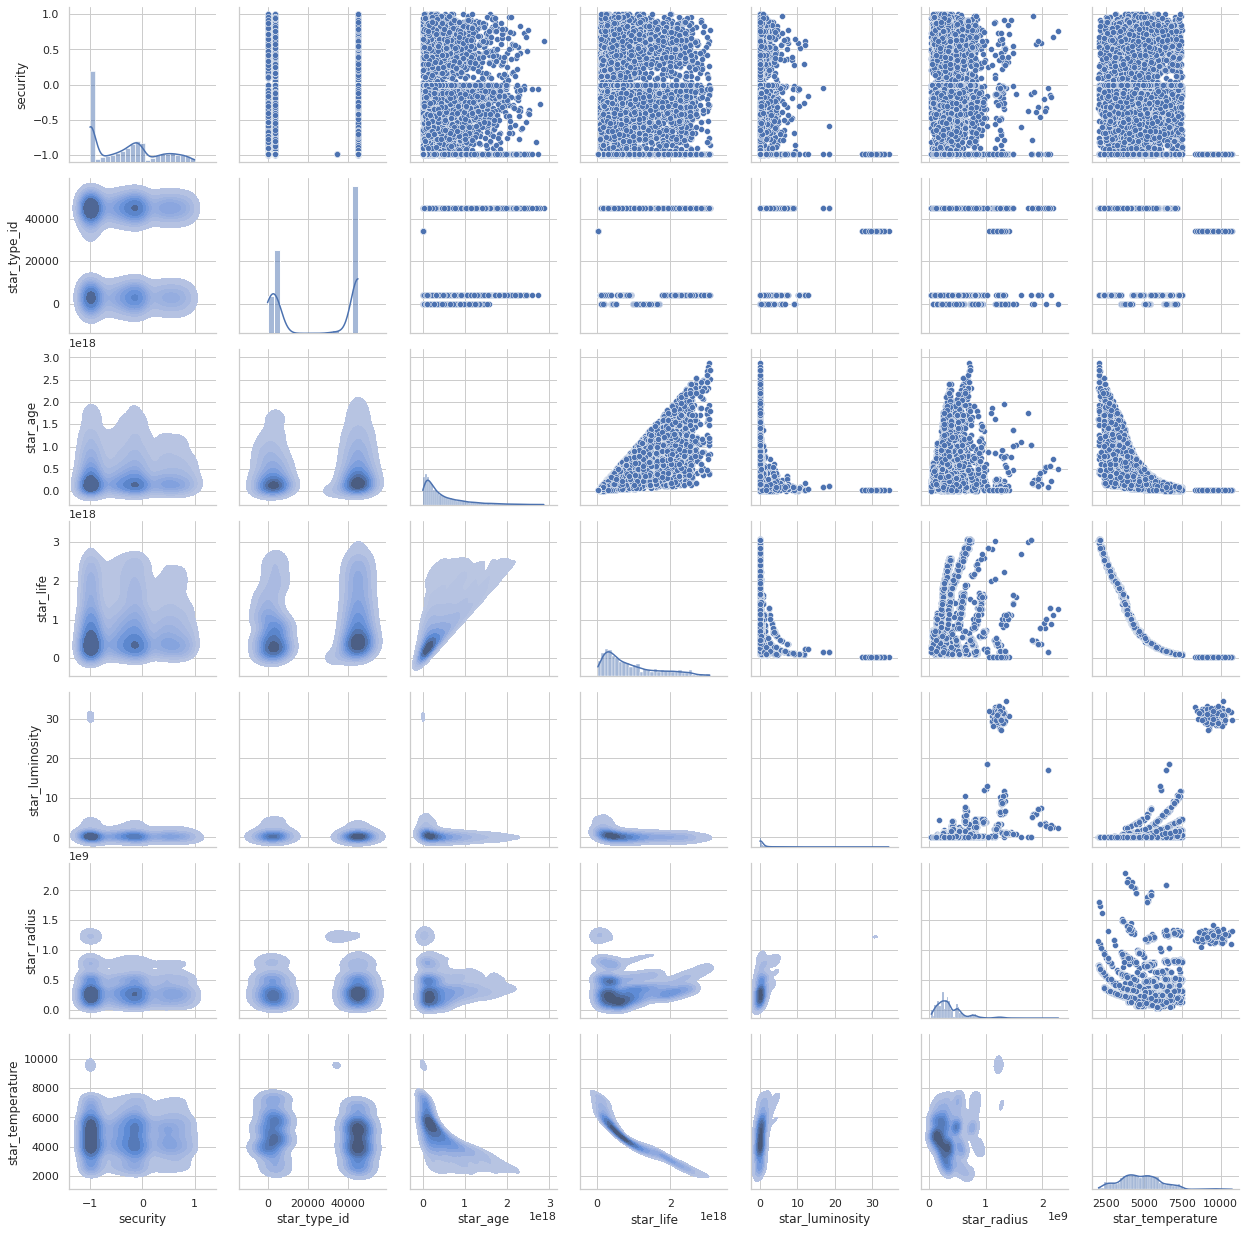

In [ ]:
# Let's just start with a PairGrid
import seaborn as sns

interesting_columns = ['security','star_type_id','star_age', 'star_life',
       'star_luminosity', 'star_radius', 'star_spectralClass',
       'star_temperature']
g = sns.PairGrid(star_data[interesting_columns])
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot, kde=True);
g.map_lower(sns.kdeplot, fill=True)

# https://seaborn.pydata.org/examples/pair_grid_with_kde.html

In [ ]:
star_data['star_type_id'].value_counts().sort_index()

6        285
7        311
8        327
9         75
10        96
3796     225
3797     311
3798     361
3799     294
3800     427
3801     251
3802     494
3803     111
34331    106
45030    298
45031    267
45032    300
45033    382
45034     72
45035     97
45036    322
45037    394
45038    342
45039    457
45040    391
45041    526
45042    132
45046     88
45047    293
Name: star_type_id, dtype: int64

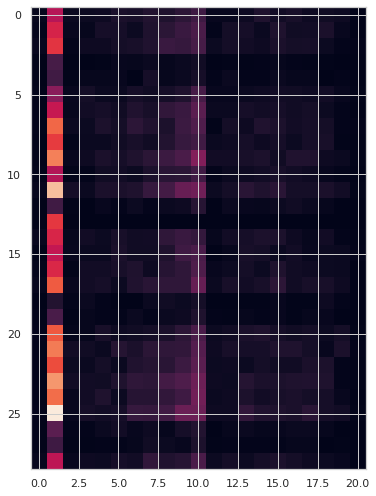

In [ ]:
star_data['star_spectralClass'].value_counts().sort_index()

A0         1
A0IV     100
A0IV2      5
F0 IV      2
F0 V      65
        ... 
M5 V     152
M6 V     168
M7 V      40
M8 V      47
M9 V      45
Name: star_spectralClass, Length: 89, dtype: int64

In [ ]:
sde_stars

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181


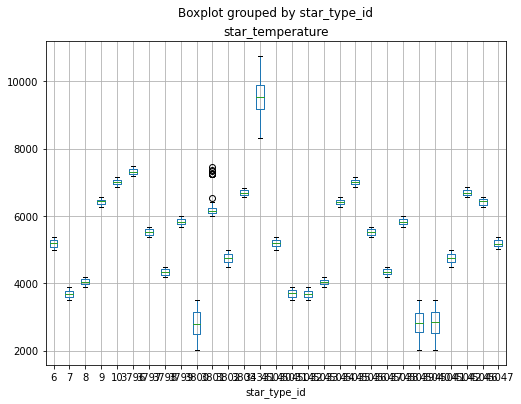

In [ ]:
sde_stars.boxplot(column='star_temperature', by='star_type_id', figsize=(8,6));

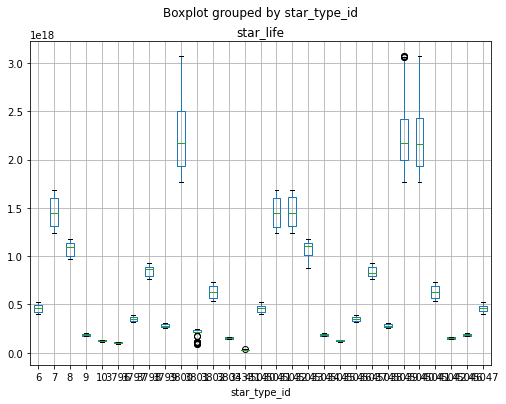

In [ ]:
sde_stars.boxplot(column='star_life', by='star_type_id', figsize=(8,6));

###The Bright Blue Giants###
There are 106 stars in Eve which are much hotter, brighter, and larger than the normal stock. One of them is Thera - the only hand-crafted system. They are all in wormhole systems, but relatively rare at 106/2604 = 4.07% of wormholes. They are hotter: 8,307-10,764 K vs 2,010-7,496 K for normal stars. And they are brighter too: 27.2-34.4 vs 0.01-18.57. They are also larger than normal stars, but the ranges overlap some. They are all star type id 34331. Their spectral classes are ['A0IV', 'A0', 'A0IV2']. It's interesting that the distribution of brightness is roughly two merged bell curves, even when you split the data by spectral class. These stars can be filtered by luminosity > 25, but also by type id 34331.

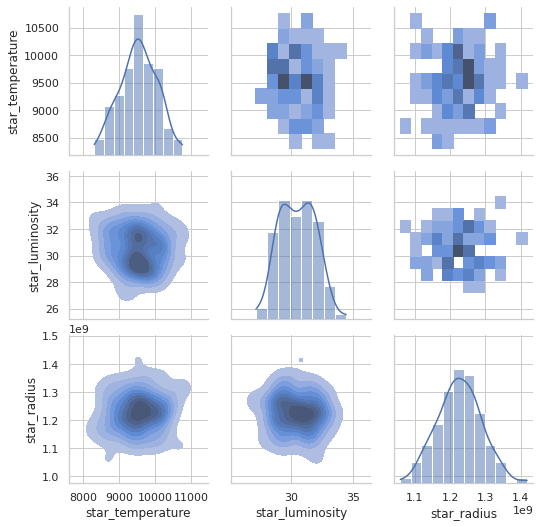

In [ ]:
# !pip install --user --upgrade seaborn
# import seaborn as sns

g = sns.PairGrid(bright_stars[['star_temperature','star_luminosity','star_radius']])
# g.map_upper(sns.histplot)
g.map_upper(sns.scatterplot, s=15)
g.map_diag(sns.histplot, kde=True);
g.map_lower(sns.kdeplot, fill=True)

# https://seaborn.pydata.org/examples/pair_grid_with_kde.html

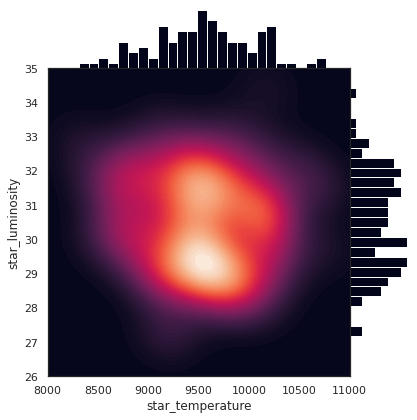

In [ ]:
# A fancy plot of the 
!pip install --user --upgrade seaborn
import seaborn as sns

bright_stars = star_data[star_data['star_type_id'] == 34331]
sns.set_theme(style="white")
g = sns.JointGrid(data=bright_stars, x="star_temperature", y="star_luminosity", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((8000, 11000), (26, 35)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25);

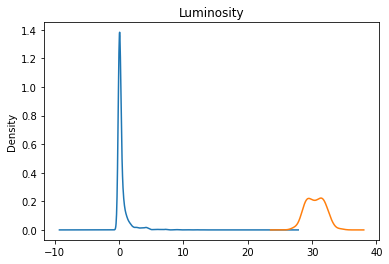

In [ ]:
normal_stars['star_luminosity'].plot.density();
bright_stars['star_luminosity'].plot.density(title='Luminosity');

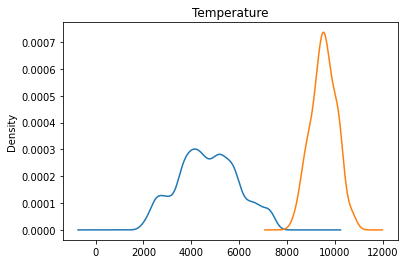

In [ ]:
normal_stars['star_temperature'].plot.density();
bright_stars['star_temperature'].plot.density(title='Temperature');

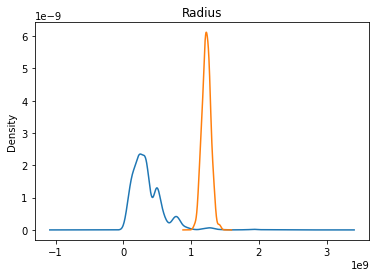

In [ ]:
normal_stars['star_radius'].plot.density();
bright_stars['star_radius'].plot.density(title='Radius');

In [ ]:
# Which are the hot bright stars?
# bright_stars = sde_stars[sde_stars['star_luminosity'] > 25]
# normal_stars = sde_stars[sde_stars['star_luminosity'] <= 25]
bright_stars = sde_stars[sde_stars['star_type_id'] == 34331]
normal_stars = sde_stars[sde_stars['star_type_id'] != 34331]
print(bright_stars['system_name'].to_numpy())
print(bright_stars['domain'].unique())

['J002216' 'J002757' 'J004317' 'J004791' 'J005834' 'J005926' 'J010569'
 'J012157' 'J012402' 'J015092' 'J001057' 'J001890' 'J002964' 'J004686'
 'J005482' 'J005900' 'J010000' 'J011321' 'J012635' 'J012735' 'J013070'
 'J013123' 'J001348' 'J001398' 'J001670' 'J002838' 'J003789' 'J004283'
 'J005923' 'J011339' 'J011563' 'J012794' 'J014348' 'J001302' 'J001769'
 'J002423' 'J002625' 'J004150' 'J004470' 'J005259' 'J005280' 'J005299'
 'J005872' 'J005969' 'J010247' 'J010556' 'J011195' 'J011355' 'J011376'
 'J011778' 'J011824' 'J001025' 'J001694' 'J001820' 'J003382' 'J003546'
 'J003793' 'J003941' 'J004128' 'J004921' 'J004998' 'J005070' 'J005223'
 'J005663' 'J005724' 'J010811' 'J011790' 'J012578' 'J012773' 'J013146'
 'J010366' 'J010951' 'J012475' 'J012686' 'J015227' 'Thera' 'J000487'
 'J000551' 'J000621' 'J000895' 'J000186' 'J000304' 'J000327' 'J000353'
 'J000452' 'J000461' 'J000522' 'J000528' 'J000595' 'J000630' 'J000965'
 'J000102' 'J000214' 'J000313' 'J000427' 'J000652' 'J000685' 'J000687'
 'J00071

In [ ]:
for col in bright_stars.columns:
  vals = len(bright_stars[col].unique())
  print(col,'=',vals)

domain = 1
region = 9
constellation = 11
system_name = 106
security = 1
solar_system_id = 106
star_id = 106
star_type_id = 1
star_age = 106
star_life = 106
star_locked = 1
star_luminosity = 106
star_radius = 106
star_spectralClass = 3
star_temperature = 106


In [ ]:
list(bright_stars['security'].unique())

[-0.99]

In [ ]:
list(bright_stars['star_type_id'].unique())

[34331]

In [ ]:
list(bright_stars['star_locked'].unique())

[False]

In [ ]:
type34 = sde_stars[sde_stars['star_type_id']==34331]
print(len(type34))

106


In [ ]:
list(bright_stars['star_spectralClass'].unique())

['A0IV', 'A0', 'A0IV2']

In [ ]:
A0IV = bright_stars[bright_stars['star_spectralClass'] == 'A0IV']
A0 = bright_stars[bright_stars['star_spectralClass'] == 'A0'] # Thera
A0IV2 = bright_stars[bright_stars['star_spectralClass'] == 'A0IV2']

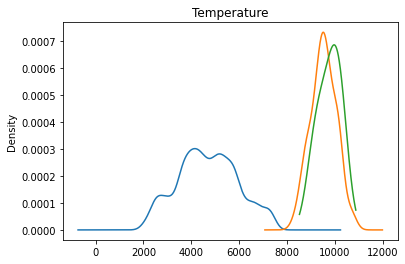

In [ ]:
normal_stars['star_temperature'].plot.density(title='Temperature');
A0IV['star_temperature'].plot.density();
A0IV2['star_temperature'].plot.density();

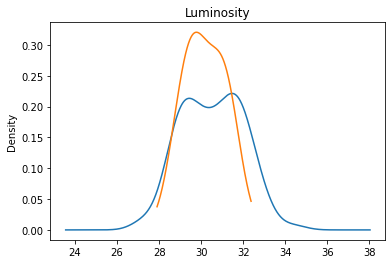

In [ ]:
A0IV['star_luminosity'].plot.density(title='Luminosity');
A0IV2['star_luminosity'].plot.density();

In [ ]:
normal_stars.describe()

,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_luminosity,star_radius,star_temperature
count,7929.000000,7.929000e+03,7.929000e+03,7929.000000,7.929000e+03,7.929000e+03,7929.000000,7.929000e+03,7929.000000
mean,-0.318592,3.031768e+07,4.024927e+07,25957.357170,4.535368e+17,9.014386e+17,0.489815,3.593022e+08,4698.299155
std,0.603728,4.636439e+05,1.417333e+05,21127.895528,4.618751e+17,7.120722e+17,1.188271,2.460101e+08,1246.278491
min,-1.000000,3.000000e+07,4.000000e+07,6.000000,6.538000e+15,9.472000e+16,0.010010,3.818500e+07,2010.000000
25%,-0.990000,3.000198e+07,4.012666e+07,3798.000000,1.265000e+17,3.314000e+17,0.029360,2.028000e+08,3815.000000
50%,-0.306624,3.000396e+07,4.025094e+07,45031.000000,2.839000e+17,6.499000e+17,0.094520,3.087000e+08,4657.000000
75%,-0.000715,3.100052e+07,4.037814e+07,45038.000000,6.306000e+17,1.291214e+18,0.403600,4.765000e+08,5585.000000
max,1.000000,3.100250e+07,4.048546e+07,45047.000000,2.873000e+18,3.077000e+18,18.570000,2.284000e+09,7496.000000


In [ ]:
bright_stars.describe()

,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_luminosity,star_radius,star_temperature
count,1.060000e+02,1.060000e+02,1.060000e+02,106.0,1.060000e+02,1.060000e+02,106.000000,1.060000e+02,106.000000
mean,-9.900000e-01,3.100241e+07,4.048803e+07,34331.0,1.503337e+16,3.144220e+16,30.512702,1.226480e+09,9541.605914
std,1.673246e-15,5.929653e+02,2.401682e+02,0.0,6.793989e+14,1.680762e+15,1.430788,6.205997e+07,516.890495
min,-9.900000e-01,3.100000e+07,4.048762e+07,34331.0,1.372426e+16,2.706883e+16,27.176355,1.059797e+09,8307.379493
25%,-9.900000e-01,3.100253e+07,4.048782e+07,34331.0,1.451541e+16,3.043356e+16,29.327555,1.188201e+09,9191.186658
50%,-9.900000e-01,3.100255e+07,4.048803e+07,34331.0,1.500486e+16,3.127447e+16,30.511095,1.223123e+09,9527.592149
75%,-9.900000e-01,3.100258e+07,4.048823e+07,34331.0,1.547099e+16,3.269967e+16,31.606368,1.264000e+09,9900.805032
max,-9.900000e-01,3.100260e+07,4.048850e+07,34331.0,1.671925e+16,3.629568e+16,34.416161,1.417298e+09,10764.116275


# Where are the Triglavians? #
Which solar systems have the Triglavians invaded?

##Looking for Invasions in the API##


In [ ]:
# Connect to the ESI API.
!pip install bravado
from bravado.client import SwaggerClient
import bravado.exception
client = SwaggerClient.from_url('https://esi.evetech.net/_latest/swagger.json?datasource=tranquility')
print('New Client connection made')

# Get player count
r = client.Status.get_status().result()
print('There are',format(r.players,',d'),'players in Eve right now!')

# https://pypi.org/project/bravado/
# https://esi.evetech.net/ui  # available EVE data

New Client connection made
There are 24,664 players in Eve right now!


The 

In [ ]:
client.Universe.get_universe_factions().result()

[get_universe_factions_200_ok(corporation_id=1000051, description='The Minmatar Republic was formed over a century ago when the Minmatar threw out their Amarrian overlords in what is now known as the Minmatar Rebellion. In this the Minmatar had the support of the Gallente Federation, and to this day the two nations remain close allies. Yet, only a quarter of the Minmatar people reside within the Republic. The rest are scattered around the star cluster, including a large portion who are still enslaved within the Amarr Empire. Minmatar individuals are independent and proud, possessing a strong will and a multitude of tribal traditions.', faction_id=500002, is_unique=True, militia_corporation_id=1000182, name='Minmatar Republic', size_factor=5.0, solar_system_id=30002544, station_count=594, station_system_count=306),
 get_universe_factions_200_ok(corporation_id=1000120, description='The Gallente Federation encompasses several races, the Gallenteans the largest by far. The Federation is de

In [ ]:
# Retrieve the Factions
r = client.Universe.get_universe_factions().result()
factions = pd.DataFrame({k : [i[k] for i in r] for k in r[0]})
get_faction_name = dict(zip(factions.faction_id, factions.name))

# This table of Faction IDs comes in handy
print('\nFactionIDs')
for (faction_id, name) in sorted(faction_name_from_id.items()):
  print(faction_id,'=',name)

# Dictionary comprehension from two columns in a result
# result = client.Universe.get_universe_factions().result()
# faction_name_from_id = {f.faction_id : f.name for f in result}

factions


FactionIDs
500001 = Caldari State
500002 = Minmatar Republic
500003 = Amarr Empire
500004 = Gallente Federation
500005 = Jove Empire
500006 = CONCORD Assembly
500007 = Ammatar Mandate
500008 = Khanid Kingdom
500009 = The Syndicate
500010 = Guristas Pirates
500011 = Angel Cartel
500012 = Blood Raider Covenant
500013 = The InterBus
500014 = ORE
500015 = Thukker Tribe
500016 = Servant Sisters of EVE
500017 = The Society of Conscious Thought
500018 = Mordu's Legion Command
500019 = Sansha's Nation
500020 = Serpentis
500021 = Unknown
500024 = Drifters
500025 = Rogue Drones
500026 = Triglavian Collective
500027 = EDENCOM


,corporation_id,description,faction_id,is_unique,militia_corporation_id,name,size_factor,solar_system_id,station_count,station_system_count
0,1000051.0,The Minmatar Republic was formed over a centur...,500002,True,1000182.0,Minmatar Republic,5.0,30002544,594,306
1,1000120.0,The Gallente Federation encompasses several ra...,500004,True,1000181.0,Gallente Federation,5.0,30004993,1072,519
2,1000137.0,CONCORD is an independent organization founded...,500006,True,NaN,CONCORD Assembly,5.0,30005204,137,93
3,1000156.0,"The Khanid Kingdom, also known as the Dark Ama...",500008,True,NaN,Khanid Kingdom,4.0,30003863,32,23
4,1000127.0,Formed by two former members of the Caldari Na...,500010,True,NaN,Guristas Pirates,4.0,30001290,9,7
5,1000134.0,The Amarr Empire has had its share of religiou...,500012,True,NaN,Blood Raider Covenant,3.0,30003088,13,12
6,1000129.0,"Outer Ring Excavations, or ORE, is the largest...",500014,True,NaN,ORE,3.0,30004504,4,2
7,1000130.0,The Sisters of EVE are mainly known for their ...,500016,True,NaN,Servant Sisters of EVE,3.0,30001978,52,39
8,1000128.0,The origin of Mordu's Legion lies in the Galle...,500018,True,NaN,Mordu's Legion Command,3.0,30002005,1,1
9,1000135.0,The Serpentis Corporation was founded a few de...,500020,True,NaN,Serpentis,4.0,30004623,25,16


In [ ]:
result = client.Incursions.get_incursions().result()
result

[get_incursions_200_ok(constellation_id=20000319, faction_id=500019, has_boss=False, infested_solar_systems=[30002165, 30002166, 30002167, 30002168, 30002169, 30002170, 30002171], influence=0.0, staging_solar_system_id=30002171, state='established', type='Incursion'),
 get_incursions_200_ok(constellation_id=20000195, faction_id=500019, has_boss=False, infested_solar_systems=[30001337, 30001338, 30001339, 30001340, 30001341, 30001342, 30001343], influence=0.0, staging_solar_system_id=30001342, state='established', type='Incursion'),
 get_incursions_200_ok(constellation_id=20000519, faction_id=500019, has_boss=True, infested_solar_systems=[30003559, 30003560, 30003561, 30003562, 30003563, 30003564], influence=1.0, staging_solar_system_id=30003563, state='withdrawing', type='Incursion'),
 get_incursions_200_ok(constellation_id=20000265, faction_id=500019, has_boss=False, infested_solar_systems=[30001792, 30001793, 30001794, 30001795, 30001789, 30001790, 30001791], influence=0.0, staging_s

In [ ]:
# ['constellation_id', 'faction_id', 'has_boss', 'infested_solar_systems', 
# 'influence', 'staging_solar_system_id', 'state', 'type']

incursions = client.Incursions.get_incursions().result()

# flat_list = [item for sublist in nested_list for item in sublist]
infested_systems = [system for incursion in incursions for system in incursion['infested_solar_systems']]
# names = [client.Universe.get_universe_systems_system_id(system_id = system).result().name for system in infested_systems]
# print('Infested systems:',names)

# add infested stars to star_data
star_data['sansha_incursion'] = star_data['solar_system_id'].isin(infested_systems)
star_data.head()

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,triglavian_kills,sansha_incursion
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.02956,125100000.0,G5 VI,5378.0,NaN,False
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.10810,155800000.0,K1 V,4713.0,NaN,False
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.29050,161000000.0,G0 V,5936.0,NaN,False
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.30090,106600000.0,F0 VI,7360.0,NaN,False
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.01935,226400000.0,K9 V,3596.0,NaN,False


In [ ]:
star_data[star_data['system_name'] == 'Niarja']

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,sansha_incursion
1187,eve,Domain,Yekti,Niarja,0.541992,30003504,40222373,3801,8.701000e+16,2.456000e+17,False,0.3235,163200000.0,F9 VI,6057.0,False


In [ ]:
niarja = client.Universe.get_universe_systems_system_id(system_id = 30003504).result()

for key in niarja:
  print(key,'=',niarja[key])

star_data[star_data['system_name'] == 'Niarja']

constellation_id = 20000788
name = Niarja
planets = [get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222374), get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222375), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222378], planet_id=40222377), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222380, 40222381], planet_id=40222379), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222383, 40222384, 40222386, 40222387, 40222388, 40222389, 40222390, 40222391, 40222392, 40222393, 40222394, 40222395], planet_id=40222382), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222397, 40222398, 40222399, 40222400, 40222401, 40222402, 40222403, 40222404, 40222405, 40222406], planet_id=40222396), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222408, 40222409], planet_id=40222407), get_universe_systems_system_id_planet(asteroid_belts=

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
1187,eve,Domain,Yekti,Niarja,0.541992,30003504,40222373,3801,8.701000e+16,2.456000e+17,False,0.3235,163200000.0,F9 VI,6057.0


In [ ]:
# Factions involved in Faction Warfare
result = client.Faction_Warfare.get_fw_stats().result()
faction_ids = [faction.faction_id for faction in result]
for id in faction_ids:
  print(faction_name_from_id[id])

Caldari State
Minmatar Republic
Amarr Empire
Gallente Federation


In EVE, the four main empires If you look be Sovereignty

In [ ]:
# Sovereignty

# # Longer code that functions the same and may be more readable
# result = client.Sovereignty.get_sovereignty_map().result()
# data = {key : [item[key] for item in result] for key in [*result[0]]}
# sovereignty = pd.DataFrame(data)

# Retrieve the Sovereignty of each Solar System
# https://esi.evetech.net/ui#/Sovereignty/get_sovereignty_map
r = client.Sovereignty.get_sovereignty_map().result()
# compact code that constructs a DataFrame from a list of dictionaries
sovereignty = pd.DataFrame({k : [i[k] for i in r] for k in r[0]})
sovereignty['faction_name'] = sovereignty.faction_id.map(get_faction_name)

# How many systems are controlled by who
print('Faction Name         Sovereignty Over X Systems')
print(sovereignty.faction_name.value_counts())

print('\n Triglavian Systems IDs')
trig_systems = list(sovereignty.system_id[sovereignty.faction_name == 'Triglavian Collective'])
print(trig_systems)

sovereignty

# https://kybernaut.space/pochven

NameError: ignored

In [ ]:
# Wars
war_ids = client.Wars.get_wars().result()
client.Wars.get_wars_war_id(war_id = war_ids[0]).result()

get_wars_war_id_ok(aggressor=get_wars_war_id_aggressor(alliance_id=99009475, corporation_id=None, isk_destroyed=0.0, ships_killed=0), allies=[], declared=datetime.datetime(2020, 9, 21, 20, 53, tzinfo=tzlocal()), defender=get_wars_war_id_defender(alliance_id=None, corporation_id=98509823, isk_destroyed=0.0, ships_killed=0), finished=None, id=691541, mutual=False, open_for_allies=False, retracted=None, started=datetime.datetime(2020, 9, 22, 20, 53, tzinfo=tzlocal()))

In [ ]:
# Corps
corp_ids = client.Corporation.get_corporations_npccorps().result()
for id in corp_ids:
  corp = client.Corporation.get_corporations_corporation_id(corporation_id = id).result()
  print(corp.name,'has',corp.member_count,'members')

CBD Corporation has 154 members
Ytiri has 85 members
Deep Core Mining Inc. has 206607 members
Minedrill has 55 members
Kaalakiota Corporation has 159 members
Top Down has 25 members
Perkone has 182053 members
Zainou has 37 members
Echelon Entertainment has 34 members
Lai Dai Corporation has 80 members
Propel Dynamics has 34 members
CBD Sell Division has 33 members
Caldari Constructions has 86 members
Caldari Funds Unlimited has 31 members
Modern Finances has 48 members
Mercantile Club has 34 members
House of Records has 20 members
Internal Security has 14 members
Ishukone Watch has 38 members
Peace and Order Unit has 35 members
Wiyrkomi Peace Corps has 19 members
School of Applied Knowledge has 1138721 members
Sebiestor Tribe has 136330 members
Vherokior Tribe has 37 members
Republic Parliament has 83 members
Republic Justice Department has 87 members
Republic Security Services has 121 members
Core Complexion Inc. has 158 members
Eifyr and Co. has 15 members
Native Freshfood has 64721 

KeyboardInterrupt: ignored

In [ ]:
properties = [*corp]

print(properties)
properties = ['alliance_id', 'ceo_id', 'creator_id', 'date_founded', 'description', 'faction_id', 'home_station_id', 'member_count', 'name', 'shares', 'tax_rate', 'ticker', 'url', 'war_eligible']


for item in corp:
  print(item,'=',corp[item])

['alliance_id', 'ceo_id', 'creator_id', 'date_founded', 'description', 'faction_id', 'home_station_id', 'member_count', 'name', 'shares', 'tax_rate', 'ticker', 'url', 'war_eligible']
alliance_id = None
ceo_id = 3019525
creator_id = 1
date_founded = None
description = An offshoot of the Imperial Shipment corporation, originally formed to provide planetary security for the shipping giant on frontier worlds and new colonies. Ametat Security now offers troops and equipment to anyone willing to pay their rates.
faction_id = None
home_station_id = 60007171
member_count = 174589
name = Ametat Security
shares = 0
tax_rate = 0.0
ticker = AMESE
url = None
war_eligible = None


In [ ]:
war_ids = client.Wars.get_wars().result()
a_war = client.Wars.get_wars_war_id(war_id = war_ids[0]).result()

# Get a list of keys in a dictionary-like object
# Does Work
properties = [*a_war]  # Fastest
# properties = list(a_war) # Slightly slower
# properties = [keyword for keyword in a_war]

# Doesn't work
# properties = **a_war
# properties = *a_war

print(properties)

for item in a_war:
  print(item,'=',a_war[item])

['aggressor', 'allies', 'declared', 'defender', 'finished', 'id', 'mutual', 'open_for_allies', 'retracted', 'started']
aggressor = get_wars_war_id_aggressor(alliance_id=99007160, corporation_id=None, isk_destroyed=0.0, ships_killed=0)
allies = []
declared = 2020-09-29 19:45:00+00:00
defender = get_wars_war_id_defender(alliance_id=None, corporation_id=98610020, isk_destroyed=0.0, ships_killed=0)
finished = None
id = 691546
mutual = False
open_for_allies = False
retracted = None
started = 2020-09-30 19:45:00+00:00


In [ ]:
import pandas as pd

corp_ids = client.Corporation.get_corporations_npccorps().result()
corp = client.Corporation.get_corporations_corporation_id(corporation_id=corp_ids[0]).result()
keys = [*corp]
# ['alliance_id', 'ceo_id', 'creator_id', 'date_founded', 'description', 'faction_id', 'home_station_id', 'member_count', 'name', 'shares', 'tax_rate', 'ticker', 'url', 'war_eligible']

corps = {key:[] for key in keys}
for i, id in enumerate(corp_ids):
  corp = client.Corporation.get_corporations_corporation_id(corporation_id=id).result()
  for key in corp:
    # print(key,'=',corp[key])
    corps[key].append(corp[key])
  print(format(i/len(corp_ids),'.2f'),'-',corp.name)
corps = pd.DataFrame(data = corps)

corps['description'] = corps['description'].replace({None:''})

0.00 - CBD Corporation
0.00 - Ytiri
0.01 - Deep Core Mining Inc.
0.01 - Minedrill
0.02 - Kaalakiota Corporation
0.02 - Top Down
0.02 - Perkone
0.03 - Zainou
0.03 - Echelon Entertainment
0.03 - Lai Dai Corporation
0.04 - Propel Dynamics
0.04 - CBD Sell Division
0.05 - Caldari Constructions
0.05 - Caldari Funds Unlimited
0.05 - Modern Finances
0.06 - Mercantile Club
0.06 - House of Records
0.06 - Internal Security
0.07 - Ishukone Watch
0.07 - Peace and Order Unit
0.08 - Wiyrkomi Peace Corps
0.08 - School of Applied Knowledge
0.08 - Sebiestor Tribe
0.09 - Vherokior Tribe
0.09 - Republic Parliament
0.10 - Republic Justice Department
0.10 - Republic Security Services
0.10 - Core Complexion Inc.
0.11 - Eifyr and Co.
0.11 - Native Freshfood
0.11 - The Leisure Group
0.12 - Carthum Conglomerate
0.12 - Viziam
0.13 - Noble Appliances
0.13 - HZO Refinery
0.13 - Imperial Shipment
0.14 - Joint Harvesting
0.14 - Further Foodstuffs
0.15 - Imperial Chancellor
0.15 - Ministry of War
0.15 - Ministry of I

In [ ]:
corps

,alliance_id,ceo_id,creator_id,date_founded,description,faction_id,home_station_id,member_count,name,shares,tax_rate,ticker,url,war_eligible
0,None,3004049,1,None,The CBD Corporation is one of the biggest expo...,NaN,60000004,154,CBD Corporation,30515077373,0.00,CBDC,None,None
1,None,3004217,1,None,Ytiri is a rare example of an outsider company...,NaN,60000310,85,Ytiri,3495338567,0.00,Y,None,None
2,None,3004089,1,None,Deep Core Mining is a young company that was f...,NaN,60000610,206607,Deep Core Mining Inc.,1319961277,0.11,DCMI,None,None
3,None,3004145,1,None,Minedrill traces its history back to the war w...,NaN,60000766,55,Minedrill,7843253908,0.00,M,None,None
4,None,3004129,1,None,"The largest of the Caldari mega corporations, ...",NaN,60000976,159,Kaalakiota Corporation,35200134523,0.00,KC,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,None,0,1,None,Codename: Scylla Infestation\r\r\n\r\r\nCONCOR...,NaN,0,0,Scylla Infestation,0,0.00,SCYLI,None,None
258,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Perun Clade,0,0.00,CLPER,None,None
259,None,3019611,1,None,CONCORD's Authority for Emergency Interdiction...,NaN,60012916,1,AEGIS,0,0.00,COAEG,None,None
260,None,1,1,None,"A wealth creation, resource exchange and data ...",NaN,60002245,0,PKN Cryptographic,0,0.00,PKNCG,None,None


In [ ]:
suspects = corps[corps['description'].str.contains("Trigl")]

for name, desc in zip(suspects['name'],suspects['description']):
  print(name+': '+desc,'\n\n')



It would seem that the Navka Overminds are either entirely suborned to Triglavian purposes or, perhaps more worryingly, are willingly working with them. 




The Veles Clade seems to be made up of many subclades and is seemingly very strong in the fields of heavy space industry, communications technology and high-energy exotic particle physics. The Veles Clade seems to prize discourse and diplomacy, after a fashion, over strife â€“ that is, if the evidence has been understood correctly. 




The Svarog Clade is apparently made up of many subclades and the evidence so far indicates strengths in combat vessel construction, the development of novel weapon systems and extensive use of bioadaptive mutaplasmid technology. The Svarog Clade seems the most aggressive and traditional, while inclined to explore new opportunities. 


The Convocation of Triglav: The Convocation of Triglav Outside the Struggle appears to be a central organizing body for the Triglavian Collective. Data recovered fr

In [ ]:
suspects

,alliance_id,ceo_id,creator_id,date_founded,description,faction_id,home_station_id,member_count,name,shares,tax_rate,ticker,url,war_eligible
124,None,0,1,None,The Navka Overminds are a form of rogue drone ...,NaN,0,0,Navka Overminds,0,0.0,NAVKA,None,None
126,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Veles Clade,0,0.0,CLVEL,None,None
127,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Svarog Clade,0,0.0,CLSVA,None,None
128,None,1,1,None,The Convocation of Triglav Outside the Struggl...,NaN,60000001,0,The Convocation of Triglav,0,0.0,CTPSV,None,None
256,None,0,1,None,The motives of the Unshackled Overminds are ob...,NaN,0,0,Unshackled Overminds,0,0.0,UNOVM,None,None
258,None,0,1,None,The Triglavian Collective has a complex social...,NaN,0,0,Perun Clade,0,0.0,CLPER,None,None
259,None,3019611,1,None,CONCORD's Authority for Emergency Interdiction...,NaN,60012916,1,AEGIS,0,0.0,COAEG,None,None


## Kill Data from zKillBoard ##

In [ ]:
# Try the zkillboard api first
# https://github.com/zKillboard/zKillboard/wiki

# If all else fails, there lots of data for webscraping
# https://zkillboard.com/faction/500026/

In [6]:
import yaml

try:
  response = !curl https://zkillboard.com/api/stats/factionID/500026/
  trig_kills = yaml.safe_load(response[0])
except yaml.YAMLError as exc:
  print(exc)

for key in sorted(trig_kills):
  print(key+':',trig_kills[key])

activepvp: {'ships': {'type': 'Ships', 'count': 11}, 'systems': {'type': 'Systems', 'count': 16}, 'regions': {'type': 'Regions', 'count': 12}, 'kills': {'type': 'Total Kills', 'count': 26}}
allTimeSum: 40722
attackersDestroyed: 154010
gangRatio: 74
groups: {'25': {'groupID': 25, 'shipsDestroyed': 4703, 'pointsDestroyed': 25541, 'iskDestroyed': 106179885458}, '26': {'groupID': 26, 'shipsDestroyed': 11234, 'pointsDestroyed': 96631, 'iskDestroyed': 803557945032}, '27': {'groupID': 27, 'shipsDestroyed': 2559, 'pointsDestroyed': 99420, 'iskDestroyed': 1957535648131}, '28': {'groupID': 28, 'shipsDestroyed': 763, 'pointsDestroyed': 1872, 'iskDestroyed': 28855873662}, '29': {'groupID': 29, 'shipsDestroyed': 1839, 'pointsDestroyed': 1839, 'iskDestroyed': 27382262253}, '31': {'groupID': 31, 'shipsDestroyed': 45, 'pointsDestroyed': 45, 'iskDestroyed': 9752801}, '237': {'groupID': 237, 'shipsDestroyed': 966, 'pointsDestroyed': 1023, 'iskDestroyed': 2776272871}, '324': {'groupID': 324, 'shipsDestro

In [ ]:
# Triglavian Kills in "topAllTime: ship"
  
ship_data = trig_kills['topAllTime'][4]['data']  # 5 = system level
kills =          [ship['kills'] for ship in ship_data]
shipTypeIDs = [ship['shipTypeID'] for ship in ship_data]
ship_kills = pd.DataFrame({'kills':kills, 'shipTypeID':shipTypeIDs})

total_kills = format(ship_kills['kills'].sum(),',d')
count = len(ship_kills['shipTypeID'].unique())
print('"topAllTime: ship" lists',total_kills,'total kills from',count,'unique ships')

ship_kills

"topAllTime: ship" lists 113,421 total kills from 100 unique ships


,kills,shipTypeID
0,38032,47465
1,37828,54577
2,5880,52645
3,5483,52649
4,2194,52646
...,...,...
95,20,52701
96,16,52473
97,14,54204
98,13,54568


In [ ]:
# Triglavian Kills in "topAllTime: system"
import pandas as pd

# for i, item in enumerate(trig_kills['topAllTime']):
#   print(i,'=',item['type'])
# 0 = character
# 1 = corporation
# 2 = alliance
# 3 = faction
# 4 = ship
# 5 = system

system_data = trig_kills['topAllTime'][5]['data']  # 5 = system level
kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_kills = pd.DataFrame({'triglavian_kills':kills, 'solarSystemID':solarSystemIDs})

total_kills = format(system_kills['triglavian_kills'].sum(),',d')
count = len(system_kills['solarSystemID'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

system_kills

"topAllTime: system" lists 60,899 total kills in 100 unique systems


,triglavian_kills,solarSystemID
0,6695,30003504
1,3616,30000182
2,2924,30001391
3,2397,30001447
4,2314,30001401
...,...,...
95,208,32000184
96,207,32000089
97,207,32000091
98,207,32000191


In [ ]:
test = star_data.merge(system_kills, how='left', left_on='solar_system_id', right_on='solarSystemID',)
test.drop(labels='solarSystemID', axis=1, inplace=True)
# test.domain.value_counts()
test

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,triglavian_kills
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,NaN
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,NaN
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,NaN
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,NaN


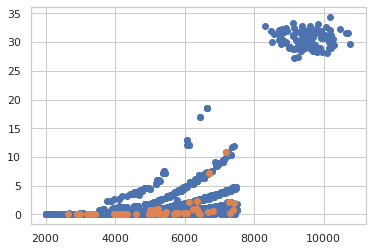

In [ ]:
import matplotlib.pyplot as plt

trig_stars = test[test.triglavian_kills > 0]
plt.scatter(x=test.star_temperature, y=test.star_luminosity)
plt.scatter(x=trig_stars.star_temperature, y=trig_stars.star_luminosity)

In [ ]:
systemid_to_name = pd.Series(star_data.system_name.values,index=star_data.solar_system_id).to_dict()

def solarID_to_sde_name(solar_system_id):
  # if ID is present in star_data, return the name from there
  if solar_system_id in star_data['solar_system_id'].values:
    return systemid_to_name[solar_system_id]

  # or get it from the abyssal and penalty sde systems
  elif str(solar_system_id) in list(system_data['system_name']):
    return str(solar_system_id)

  else:
    return np.nan

def solarID_to_esi_name(solar_system_id):
  # if ID is present in star_data, return the name from there
  if solar_system_id in star_data['solar_system_id'].values:
    return systemid_to_name[solar_system_id]

  # else look it up in the ESI
  else:
    try:
      system = client.Universe.get_universe_systems_system_id(system_id=solar_system_id).result()
      return system.name

    except:
      return np.nan

system_kills['sde_name'] = system_kills['solar_system_id'].apply(solarID_to_sde_name)
system_kills['esi_name'] = system_kills['solar_system_id'].apply(solarID_to_esi_name)
system_kills
# for solar_id in system_kills['solar_system_id']:
#   name = solarID_to_name(solar_id)
#   print(solar_id,'=',name)

,kills,solar_system_id,sde_name,esi_name
0,6695,30003504,Niarja,Niarja
1,3616,30000182,Inaya,Inaya
2,2924,30001391,Piekura,Piekura
3,2397,30001447,Taisy,Taisy
4,2314,30001401,Nonni,Nonni
...,...,...,...,...
95,208,32000184,32000184,AD184
96,207,32000089,32000089,AD089
97,207,32000091,32000091,AD091
98,207,32000191,32000191,AD191


In [ ]:
system_kills = system_kills.merge(star_data[['solar_system_id','system_name']], how='inner',
                                  left_on='solar_system_id', right_on='solar_system_id')
system_kills

,kills,solar_system_id,system_name_x,system_name_y
0,6695,30003504,Niarja,Niarja
1,3616,30000182,Inaya,Inaya
2,2924,30001391,Piekura,Piekura
3,2397,30001447,Taisy,Taisy
4,2314,30001401,Nonni,Nonni
5,2307,30000205,Obe,Obe
6,1959,30003495,Raravoss,Raravoss
7,1866,30045329,Ichoriya,Ichoriya
8,1858,30045338,Hikkoken,Hikkoken
9,1629,30000163,Akora,Akora


In [ ]:
# Parse and Extract data from sde.zip

from zipfile import ZipFile
import re
import numpy as np
import yaml
import pandas as pd

# from https://developers.eveonline.com/resource/resources
# https://www.geeksforgeeks.org/working-zip-files-python/

# Get solar system file paths
def getPaths(domains):
  system_file_paths = []
  with ZipFile('sde.zip', 'r') as zip:
    sde_files = zip.namelist()
    for domain in domains:
      pattern = '(^sde/fsd/universe/' +domain+ '.+/solarsystem.staticdata$)'
      matches = (re.search(pattern, line) for line in sde_files)
      system_file_paths.extend([match.group(1) for match in matches if match])
    zip.close()
  return system_file_paths

# All domains are ['abyssal', 'eve', 'penalty', 'wormhole']
system_file_paths = getPaths(['abyssal', 'eve', 'penalty', 'wormhole'])
print('Got file paths for',format(len(system_file_paths),',d'),'solar system files')

def extract_stars_from_sde():
  data = {'domain':[],
          'region':[],
          'constellation':[],
          'system_name':[]}
          
  for i, filepath in enumerate(system_file_paths):
    (_,_,_,domain,region,constellation,system_name,_) = filepath.split('/')

    # File path components
    data['domain'].append(domain if domain else None)
    data['region'].append(region if region else None)
    data['constellation'].append(constellation if constellation else None)
    data['system_name'].append(system_name if system_name else None)

  return pd.DataFrame(data)
system_data = extract_stars_from_sde()
system_data

Got file paths for 8,285 solar system files


,domain,region,constellation,system_name
0,abyssal,12000001,22000001,32000001
1,abyssal,12000001,22000001,32000002
2,abyssal,12000001,22000001,32000003
3,abyssal,12000001,22000001,32000004
4,abyssal,12000001,22000001,32000005
...,...,...,...,...
8280,wormhole,K-R00033,K-C00334,J055520
8281,wormhole,K-R00033,K-C00334,J110145
8282,wormhole,K-R00033,K-C00334,J164710
8283,wormhole,K-R00033,K-C00334,J174618


In [ ]:
system_data[system_data['system_name'] == '32000107']

,domain,region,constellation,system_name
106,abyssal,12000003,22000014,32000107


In [ ]:
system = client.Universe.get_universe_systems_system_id(system_id = 32000158).result()
for key in sorted(system):
  print(key,'=',system[key])

constellation_id = 22000020
name = AD158
planets = None
position = get_universe_systems_system_id_position(x=4.284860289421954e+18, y=5.160541259488124e+18, z=-6.026009229334713e+18)
security_class = None
security_status = -0.9900000095367432
star_id = None
stargates = None
stations = None
system_id = 32000158


In [ ]:
system_kills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   kills            100 non-null    int64
 1   solar_system_id  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


In [ ]:
# Triglavian Kills in "topLists: solarSystem"
import pandas as pd

# for i, item in enumerate(trig_kills['topLists']):
#   print(i,'=',item['type'])
# 0 = character
# 1 = corporation
# 2 = alliance
# 3 = shipType
# 4 = solarSystem
# 5 = location

system_data = trig_kills['topLists'][4]['values']  # 4 = system level

kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_top_kills = pd.DataFrame({'kills':kills, 'solarSystemID':solarSystemIDs})

total_kills = format(system_top_kills['kills'].sum(),',d')
count = len(system_top_kills['solarSystemID'].unique())
print('"topLists: solarSystem" lists',total_kills,'total kills in',count,'unique systems')

system_top_kills

"topLists: solarSystem" lists 915 total kills in 10 unique systems


,kills,solarSystemID
0,391,30003504
1,174,30001400
2,70,30001391
3,45,30005330
4,45,30000163
5,44,30001401
6,40,30003495
7,36,30020141
8,35,30045354
9,35,30010141


In [ ]:
# Triglavian Kills by Months
import pandas as pd

month_yaml = trig_kills['months']  # 5 = system level
month_data = {}
month_data['iskDestroyed'] = [month_yaml[key]['iskDestroyed'] for key in month_yaml]
month_data['shipsDestroyed'] = [month_yaml[key]['shipsDestroyed'] for key in month_yaml]
month_data['years'] = [month_yaml[key]['year'] for key in month_yaml]
month_data['months'] = [month_yaml[key]['month'] for key in month_yaml]
month_data = pd.DataFrame(month_data)

total_kills = format(month_data['shipsDestroyed'].sum(),',d')
total_isk =   format(month_data['iskDestroyed'].sum(),',d')
count = len(month_yaml)
print('"months" lists',total_kills,'total kills and',total_isk,'total isk lost over',count,'months')

month_data

"months" lists 40,856 total kills and 5,165,829,584,055 total isk lost over 14 months


,iskDestroyed,shipsDestroyed,years,months
0,43548904493,70,2019,9
1,172835382075,272,2019,10
2,234680330045,348,2019,11
3,429766211232,564,2019,12
4,331170373343,454,2020,1
5,139203207114,191,2020,2
6,95073168442,138,2020,3
7,112219189021,195,2020,4
8,198230305417,710,2020,5
9,128912150771,782,2020,6


In [ ]:
# Triglavian Kills by Ship GroupID
import pandas as pd

group_data = trig_kills['groups']  # 5 = system level
kills =   [group_data[group]['shipsDestroyed'] for group in group_data]
groupID = [group_data[group]['groupID'] for group in group_data]
group_kills = pd.DataFrame({'groupID':groupID, 'shipsDestroyed':kills})

total_kills = format(group_kills['shipsDestroyed'].sum(),',d')
count = len(group_kills['groupID'].unique())
print('"groups" lists',total_kills,'total kills in',count,'unique groupIDs')

group_kills.head()

"groups" lists 40,886 total kills in 45 unique groupIDs


,groupID,shipsDestroyed
0,25,4694
1,26,11231
2,27,2559
3,28,763
4,29,1839


In [ ]:
print('Total Triglavian Kills:\n')

# allTimeSum
total_kills = format(trig_kills['allTimeSum'],',d')
print('"allTimeSum" says there are',total_kills,'total kills.')

# iskDestroyed
total_isk = format(trig_kills['iskDestroyed'], ',d')
print('"iskDestroyed" says a total of',total_isk,'has been lost.')

# shipsDestroyed
total_kills = format(trig_kills['shipsDestroyed'],',d')
print('"shipsDestroyed" says there are',total_kills,'total kills.')

# topAllTime: system
total_kills = format(system_kills['kills'].sum(),',d')
count = len(system_kills['solar_system_id'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

# topAllTime: ship
total_kills = format(ship_kills['kills'].sum(),',d')
count = len(ship_kills['shipTypeID'].unique())
print('"topAllTime: ship" lists',total_kills,'total kills from',count,'unique ships')

# topLists: solarSystem
total_kills = format(system_top_kills['kills'].sum(),',d')
count = len(system_top_kills['solarSystemID'].unique())
print('"topLists: solarSystem" lists',total_kills,'total kills in',count,'unique systems')

# months
total_kills = format(month_data['shipsDestroyed'].sum(),',d')
total_isk =   format(month_data['iskDestroyed'].sum(),',d')
count = len(month_yaml)
print('"months" lists',total_kills,'total kills and',total_isk,'total isk lost over',count,'months')

# ship groups
total_kills = format(group_kills['shipsDestroyed'].sum(),',d')
count = len(group_kills['groupID'].unique())
print('"groups" lists',total_kills,'total kills from',count,'unique ship groupIDs')

Total Triglavian Kills:

"allTimeSum" says there are 40,722 total kills.
"iskDestroyed" says a total of 5,195,889,585,362 has been lost.
"shipsDestroyed" says there are 40,886 total kills.


KeyError: ignored

In [ ]:
# Different sources disagree over Niarja's basics

niarja = client.Universe.get_universe_systems_system_id(system_id = 30003504).result()
for key in sorted(niarja):
  print(key,'=',niarja[key])

# From SDE.zip
star_data[star_data['system_name'] == 'Niarja']

# From zKillBoard
# {'constellationID': 20000788,
#   'constellationName': 'Krai Svarog',
#   'id': 30003504,
#   'kills': 409,
#   'name': 'Niarja',
#   'regionID': None,
#   'solarSystemID': 30003504,
#   'solarSystemName': 'Niarja',
#   'solarSystemSecurity': '-1.0',
#   'sunTypeID': 56085,
#   'systemColorCode': '#F30202',
#   'typeID': None}

constellation_id = 20000788
name = Niarja
planets = [get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222374), get_universe_systems_system_id_planet(asteroid_belts=None, moons=None, planet_id=40222375), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222378], planet_id=40222377), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222380, 40222381], planet_id=40222379), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222383, 40222384, 40222386, 40222387, 40222388, 40222389, 40222390, 40222391, 40222392, 40222393, 40222394, 40222395], planet_id=40222382), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222397, 40222398, 40222399, 40222400, 40222401, 40222402, 40222403, 40222404, 40222405, 40222406], planet_id=40222396), get_universe_systems_system_id_planet(asteroid_belts=None, moons=[40222408, 40222409], planet_id=40222407), get_universe_systems_system_id_planet(asteroid_belts=

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature
1187,eve,Domain,Yekti,Niarja,0.541992,30003504,40222373,3801,8.701000e+16,2.456000e+17,False,0.3235,163200000.0,F9 VI,6057.0


In [ ]:
# Get Sansha Kills per System and merge into star_data
import yaml
import pandas as pd

# 500019 = Sansha's Nation
# 500024 = Drifters
try:
  response = !curl https://zkillboard.com/api/stats/factionID/500019/
  trig_kills = yaml.safe_load(response[0])
except yaml.YAMLError as exc:
  print(exc)

system_data = trig_kills['topAllTime'][5]['data']  # 5 = system level
kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_kills = pd.DataFrame({'sansha_kills':kills, 'solar_system_id':solarSystemIDs})

total_kills = format(system_kills['sansha_kills'].sum(),',d')
count = len(system_kills['solar_system_id'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

star_data = star_data.merge(system_kills, how='left', on='solar_system_id')
star_data.head()

"topAllTime: system" lists 131,267 total kills in 100 unique systems


,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,triglavian_kills,sansha_incursion,sansha_kills
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.02956,125100000.0,G5 VI,5378.0,NaN,False,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.10810,155800000.0,K1 V,4713.0,NaN,False,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.29050,161000000.0,G0 V,5936.0,NaN,False,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.30090,106600000.0,F0 VI,7360.0,NaN,False,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.01935,226400000.0,K9 V,3596.0,NaN,False,NaN


In [ ]:
# Get Drifter Kills per System and merge into star_data
import yaml
import pandas as pd
import matplotlib.pyplot as plt

# 500019 = Sansha's Nation
# 500024 = Drifters
try:
  response = !curl https://zkillboard.com/api/stats/factionID/500024/
  trig_kills = yaml.safe_load(response[0])
except yaml.YAMLError as exc:
  print(exc)

system_data = trig_kills['topAllTime'][5]['data']  # 5 = system level
kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_kills = pd.DataFrame({'drifter_kills':kills, 'solar_system_id':solarSystemIDs})

total_kills = format(system_kills['drifter_kills'].sum(),',d')
count = len(system_kills['solar_system_id'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

star_data = star_data.merge(system_kills, how='left', on='solar_system_id')
star_data.head()

"topAllTime: system" lists 36,076 total kills in 100 unique systems


,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,triglavian_kills,sansha_incursion,sansha_kills,drifter_kills
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.02956,125100000.0,G5 VI,5378.0,NaN,False,NaN,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.10810,155800000.0,K1 V,4713.0,NaN,False,NaN,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.29050,161000000.0,G0 V,5936.0,NaN,False,NaN,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.30090,106600000.0,F0 VI,7360.0,NaN,False,NaN,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.01935,226400000.0,K9 V,3596.0,NaN,False,NaN,NaN


"topAllTime: system" lists 60,899 total kills in 100 unique systems


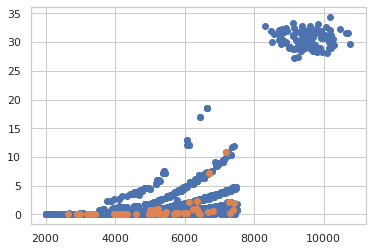

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,triglavian_kills,trig_present,sansha_incursion
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.02956,125100000.0,G5 VI,5378.0,NaN,NaN,False
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.10810,155800000.0,K1 V,4713.0,NaN,NaN,False
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.29050,161000000.0,G0 V,5936.0,NaN,NaN,False
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.30090,106600000.0,F0 VI,7360.0,NaN,NaN,False
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.01935,226400000.0,K9 V,3596.0,NaN,NaN,False


In [ ]:
# Get Triglavian Kills per System and merge into star_data
import yaml
import pandas as pd
import matplotlib.pyplot as plt

try:
  response = !curl https://zkillboard.com/api/stats/factionID/500026/
  trig_kills = yaml.safe_load(response[0])
except yaml.YAMLError as exc:
  print(exc)

system_data = trig_kills['topAllTime'][5]['data']  # 5 = system level
kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_kills = pd.DataFrame({'triglavian_kills':kills, 'solar_system_id':solarSystemIDs, 'trig_present':True})

total_kills = format(system_kills['triglavian_kills'].sum(),',d')
count = len(system_kills['solar_system_id'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

star_data = star_data.merge(system_kills, how='left', on='solar_system_id')

incursions = client.Incursions.get_incursions().result()
infested_systems = [system for incursion in incursions for system in incursion['infested_solar_systems']]
star_data['sansha_incursion'] = star_data['solar_system_id'].isin(infested_systems)

trig_stars = star_data[star_data.triglavian_kills > 0]
# sans_stars = star_data[star_data.sansha_kills > 0]
# drif_stars = star_data[star_data.drifter_kills > 0]
plt.scatter(x=test.star_temperature, y=test.star_luminosity)
plt.scatter(x=trig_stars.star_temperature, y=trig_stars.star_luminosity)
# plt.scatter(x=sans_stars.star_temperature, y=sans_stars.star_luminosity)
# plt.scatter(x=drif_stars.star_temperature, y=sans_stars.star_luminosity)
plt.show()

star_data.head()

In [ ]:
# Find the invaded systems for the Triglavians, Drifters, and Sansha's Nation and apply to star_data
import yaml
import pandas as pd

def invaded_systems(faction_id):
  try:
    url = 'https://zkillboard.com/api/stats/factionID/'+str(faction_id)+'/'
    response = !curl {url}
    kill_stats = yaml.safe_load(response[0])
  except yaml.YAMLError as exc:
    print(exc)
  system_data = kill_stats['topAllTime'][5]['data']  # 5 = system level
  invaded_systems = [system['solarSystemID'] for system in system_data]
  return invaded_systems

sans_systems = invaded_systems(500019)  # 500019 = Sansha's Nation
drif_systems = invaded_systems(500024)  # 500024 = Drifters
trig_systems = invaded_systems(500026)  # 500026 = Triglavian Collective

def invaded_by(system_id):
  if system_id in sans_systems:
    return 'Sansha'
  elif system_id in drif_systems:
    return 'Drifters'
  elif system_id in trig_systems:
    return 'Triglavians'
  else:
    return None

star_data['invader'] = star_data['solar_system_id'].apply(invaded_by)
star_data

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,invader
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,None
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,None
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,None
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,None
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,Drifters
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,Drifters
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,Drifters
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,Drifters


In [ ]:
star_data['invader'].value_counts()

Sansha         100
Triglavians     53
Drifters        15
Name: invader, dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


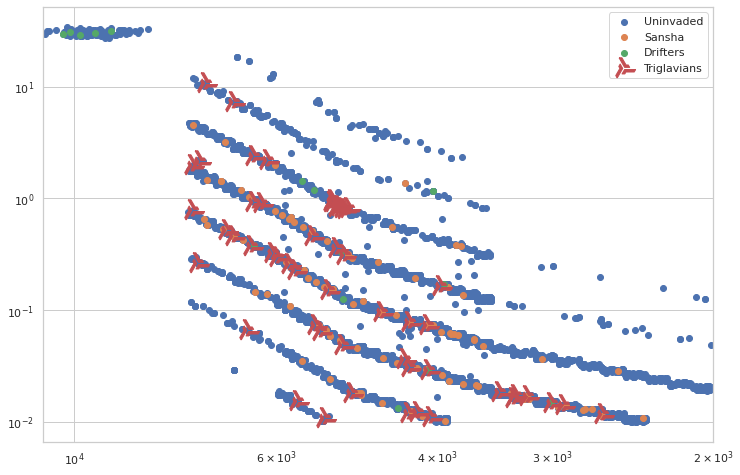

In [ ]:
norm_stars = star_data[star_data.invader == None]
sans_stars = star_data[star_data.invader == 'Sansha']
drif_stars = star_data[star_data.invader == 'Drifters']
trig_stars = star_data[star_data.invader == 'Triglavians']

plt.figure(figsize=(12,8))
plt.scatter(x=star_data.star_temperature, y=star_data.star_luminosity, label='Uninvaded')
plt.scatter(x=sans_stars.star_temperature, y=sans_stars.star_luminosity, label='Sansha')
plt.scatter(x=drif_stars.star_temperature, y=drif_stars.star_luminosity, label='Drifters')
plt.scatter(x=trig_stars.star_temperature, y=trig_stars.star_luminosity, label='Triglavians', marker=trig_logo, s=500)
plt.axes().set(xlim=(10800, 2000))
plt.axes().set(xscale='log', yscale='log')
plt.legend()
plt.show()

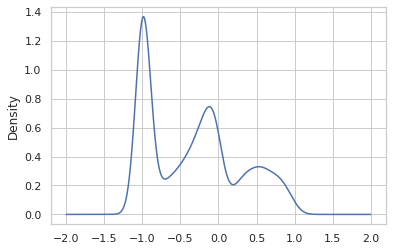

In [ ]:
star_data.security.plot.density()

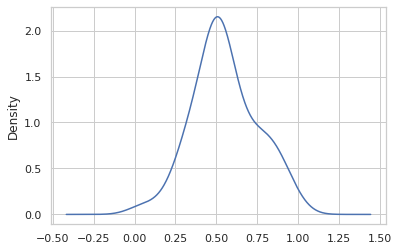

In [ ]:
trig_stars.security.plot.density()

In [9]:
# Summary Code which adds Triglavian Kills to star_data
import yaml
import pandas as pd

try:
  response = !curl https://zkillboard.com/api/stats/factionID/500026/
  trig_kills = yaml.safe_load(response[0])
except yaml.YAMLError as exc:
  print(exc)

system_data = trig_kills['topAllTime'][5]['data']  # 5 = system level
kills =          [system['kills'] for system in system_data]
solarSystemIDs = [system['solarSystemID'] for system in system_data]
system_kills = pd.DataFrame({'triglavian_kills':kills, 'solarSystemID':solarSystemIDs})

total_kills = format(system_kills['triglavian_kills'].sum(),',d')
count = len(system_kills['solarSystemID'].unique())
print('"topAllTime: system" lists',total_kills,'total kills in',count,'unique systems')

star_data = star_data.merge(system_kills, how='left', left_on='solar_system_id', right_on='solarSystemID',)
star_data.drop(labels='solarSystemID', axis=1, inplace=True)
star_data

"topAllTime: system" lists 60,899 total kills in 100 unique systems


,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,invader,triglavian_kills
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,NaN,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,NaN,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,NaN,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,NaN,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,Drifters,NaN
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,Drifters,NaN
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,Drifters,NaN
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,Drifters,NaN


## Invasions on kybernaut.space ##

After all of this, two people on Reddit mentioned 
https://kybernaut.space/invasions to find a list of Triglavian Invasions. This lists 192 invasions, far better than anything else I found on my own. This site also details the stage of the invasion, which I didn't have. I have no idea where this site derived their information. All of the invasions are conveniently packaged in a JSON file.

In [10]:
# Load and parse the list of invasions on kybernaut.space
import json

result = !curl https://kybernaut.space/invasions.json
invasions = json.loads(result[0])
invasions = pd.DataFrame(invasions)
invasions = invasions.rename(columns={'status': 'invasion_status', 'system_id': 'solar_system_id'})
invasions

,solar_system_id,invasion_status,derived_security_status,updated_at,system_name,system_security,system_sovereignty
0,30003088,edencom_minor_victory,None,2020-10-04T12:29:02.888Z,Oyonata,0.3,amarr
1,30003894,edencom_minor_victory,None,2020-10-01T18:28:09.852Z,Sabusi,0.5,amarr
2,30004302,edencom_minor_victory,None,2020-09-30T15:36:50.977Z,Omigiav,0.2,amarr
3,30003539,fortress,None,2020-09-30T14:11:30.759Z,Miakie,0.5,amarr
4,30005074,edencom_minor_victory,None,2020-09-30T14:02:33.042Z,Daran,0.2,amarr
...,...,...,...,...,...,...,...
187,30005260,fortress,None,2020-06-03T04:02:40.650Z,Keri,0.4,amarr
188,30000105,fortress,None,2020-06-03T04:02:40.650Z,Abha,0.4,amarr
189,30004992,fortress,None,2020-06-03T04:02:40.650Z,Palmon,0.4,gallente
190,30002243,fortress,None,2020-06-03T04:02:40.650Z,Seiradih,0.6,amarr


In [11]:
sub = invasions[['solar_system_id', 'invasion_status']]
star_data = star_data.merge(sub, how='left', on='solar_system_id')
trig_stars = star_data[star_data['invasion_status'].notnull()]
star_data

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,invader,triglavian_kills,invasion_status
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,NaN,NaN,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,NaN,NaN,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,NaN,NaN,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,NaN,NaN,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,Drifters,NaN,NaN
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,Drifters,NaN,NaN
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,Drifters,NaN,NaN
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,Drifters,NaN,NaN


In [ ]:
# The counts of each severity of invasion.
# The actual order from we're winning to they're winning goes
# edencom_minor_victory > triglavian_minor_victory > fortress > final_liminality
print(star_data.invasion_status.value_counts())
print('total',star_data.invasion_status.value_counts().sum())

edencom_minor_victory       84
fortress                    53
triglavian_minor_victory    28
final_liminality            27
Name: invasion_status, dtype: int64
total 192


# The Star Plot #


I recreated a [Hertzsprung-Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram) for the stars of Eve Online. Briefly, it plots a sample of stars by color/temperature and brightness, both on log scales. This separates stars into main sequence stars and other types. As the main sequence stars age, they travel from the upper left corner, down to the lower right corner.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png" width="720">


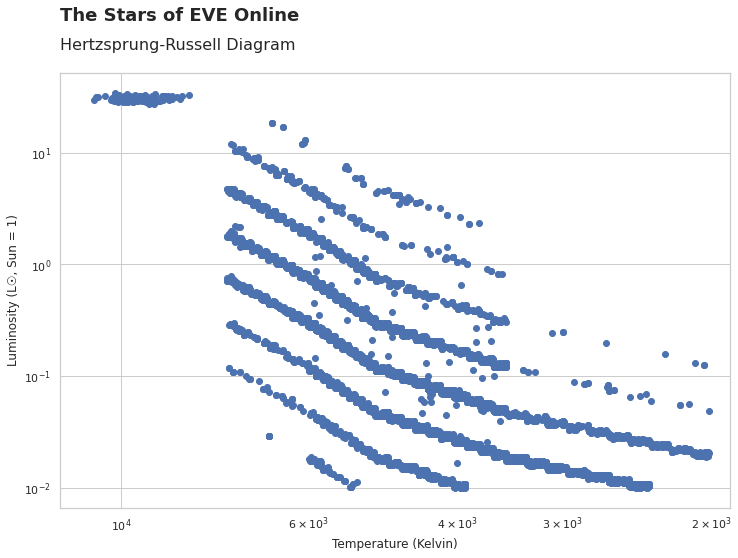

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
ax = plt.gca()
plt.scatter(x=star_data.star_temperature, y=star_data.star_luminosity)

#  Title and Subtitle
alignment = dict(ha='left', x=0.125)
fig.text(s='The Stars of EVE Online',
           fontsize=18, fontweight='bold', **alignment, y=0.97)
fig.text(s='Hertzsprung-Russell Diagram',
           fontsize=16, **alignment, y=0.92)

# Spines & Gridlines
ax.set(xlabel='Temperature (Kelvin)', ylabel='Luminosity (L☉, Sun = 1)')
ax.set(xlim=(11800, 1900), xscale='log', yscale='log')
plt.show()

## Scatter Symbol ##

In [ ]:
# The Triglavian logo for a scatter marker
!pip install svgpathtools
!pip install svgpath2mpl
import os.path
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

trig_logo_file = 'triglavian_logo.svg'
if not os.path.exists(trig_logo_file):
  !wget https://github.com/jrslagle/EVE-Triglavian-Invasions/raw/main/triglavian_logo.svg

paths, attributes = svg2paths(trig_logo_file)
trig_logo = parse_path(paths[0].d())
# center the marker
trig_logo.vertices -= trig_logo.vertices.mean(axis=0)

     |████████████████████████████████| 51kB 877kB/s 
     |████████████████████████████████| 71kB 2.1MB/s 
--2020-10-22 19:41:33--  https://github.com/jrslagle/EVE-Triglavian-Invasions/raw/main/triglavian_logo.svg
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jrslagle/EVE-Triglavian-Invasions/main/triglavian_logo.svg [following]
--2020-10-22 19:41:33--  https://raw.githubusercontent.com/jrslagle/EVE-Triglavian-Invasions/main/triglavian_logo.svg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2009 (2.0K) [image/svg+xml]
Saving to: ‘triglavian_logo.svg’

triglavian_logo.svg 100%[===================>

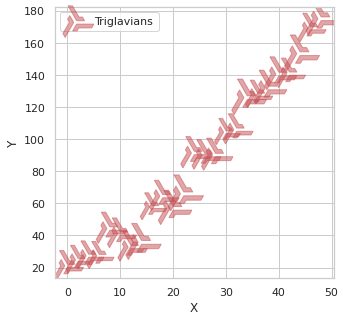

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

x = np.arange(0.0, 50.0, 2.0) # from 0 to 50, every 2
y = x ** 1.3 + np.random.rand(*x.shape) * 30.0
s = np.random.rand(*x.shape) * 800 + 800

plt.figure(figsize=(5,5))
plt.scatter(x, y, s, c="r", alpha=0.5, marker=trig_logo, label="Triglavians")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper left')
plt.show()

## Star Color ##

<img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Pahoehoe_toe.jpg" width=70%>

I wanted to get the star color *accurate*. Stars produce light because they are hot. The mixture of colors that comes off a hot object is the [Black Body Spectrum](https://en.wikipedia.org/wiki/Black-body_radiation).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Black_body.svg/500px-Black_body.svg.png" width=60%>

It doesn't matter what material the object is made of (hydrogen, steel, lava), they all produce the same colors at the same temperatures (plus their color when they're cold). This mixture of colors determines the overall color we percieve. These colors can be placed on a scale vs temperature (in kelvin below).
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Color_temperature_black_body_800-12200K.svg/1000px-Color_temperature_black_body_800-12200K.svg.png" width=90%>

In matplotlib, a gradually changing color scale is called a colormap. I sought to create my own colormap, that follows the black body spectrum. However, there's a problem with making this a fixed colormap. Colormaps set their start and end points to the minimum and maximum values in your data, and different temperature series may have different min and max values, and thus different starting and ending colors.

To address this, I created a function which accepts a Pandas Series as input, and returns a colormap of the blackbody spectrum for that range of temperatures (in Kelvin). This function actually used to scrape a website, compile a dataframe of Temp (K), Red, Green, Blue columns, take the min and max of the given Series, segment the dataframe, cast it into a list of (R,G,B) tuples, and construct a colormap from that. Now the dataframe is loaded from a file, in case the original website disappears.

In [ ]:
import re
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

html = !curl http://www.vendian.org/mncharity/dir3/blackbody/UnstableURLs/bbr_color_D58.html

#  Temp    Width  Chromacity     Power        Red    Green  Blue    Red Gre Blu  RGB Hex
#  1000 K  10deg  0.6472 0.3506  2.525e+06    1.0000 0.0475 0.0000  255  62   0  #ff3e00
# 40000 K  10deg  0.2460 0.2489  1.931e+17    0.2621 0.4546 1.0000  140 180 255  #8cb4ff

pattern = '(\d{4,5}) K  10deg.+    ([\d\.]{6}) ([\d\.]{6}) ([\d\.]{6}) '
matches = [ re.search(pattern, line) for line in html ]
color_scale = [ match.groups() for match in matches if match ]
column_names = ['Temp (K)','Red','Green','Blue']
color_scale = pd.DataFrame(color_scale, columns=column_names)
color_scale

,Temp (K),Red,Green,Blue
0,1000,1.0000,0.0475,0.0000
1,1100,1.0000,0.0736,0.0000
2,1200,1.0000,0.0994,0.0000
3,1300,1.0000,0.1248,0.0000
4,1400,1.0000,0.1493,0.0000
...,...,...,...,...
386,39600,0.2626,0.4551,1.0000
387,39700,0.2624,0.4550,1.0000
388,39800,0.2623,0.4549,1.0000
389,39900,0.2622,0.4548,1.0000


In [ ]:
# Save dataframe to zip file
from google.colab import files

# save a dataframe into a zip file
compression_opts = dict(method='zip', archive_name='blackbody_colors.csv')
color_scale.to_csv('blackbody_colors.zip', index=False, compression=compression_opts)

# download a copy to your local machine so you can upload it later or host it
files.download('blackbody_colors.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# A function which accepts a Pandas Series of temperatures in kelvin
# and returns a colormap matching the black body spectrum for those temperatures
def blackbody_color_map(series, N=256):
  import re
  import pandas as pd
  import numpy as np
  from matplotlib.colors import ListedColormap, LinearSegmentedColormap

  html = !curl http://www.vendian.org/mncharity/dir3/blackbody/UnstableURLs/bbr_color_D58.html

  #  Temp    Width  Chromacity     Power        Red    Green  Blue    Red Gre Blu  RGB Hex
  #  1000 K  10deg  0.6472 0.3506  2.525e+06    1.0000 0.0475 0.0000  255  62   0  #ff3e00
  # 40000 K  10deg  0.2460 0.2489  1.931e+17    0.2621 0.4546 1.0000  140 180 255  #8cb4ff

  pattern = '(\d{4,5}) K  10deg.+    ([\d\.]{6}) ([\d\.]{6}) ([\d\.]{6}) '
  matches = [ re.search(pattern, line) for line in html ]
  color_scale = [ match.groups() for match in matches if match ]
  column_names = ['Temp (K)','Red','Green','Blue']
  color_scale = pd.DataFrame(color_scale, columns=column_names)

  # cast string data into numbers
  color_scale['Temp (K)'] = color_scale['Temp (K)'].astype(int)
  for column in color_scale.columns[1:]:
    color_scale[column] = color_scale[column].astype(float)
  
  start_temp = np.floor(series.min()/100).astype(int)*100
  end_temp = np.ceil(series.max()/100).astype(int)*100
  temps = color_scale['Temp (K)']
  color_scale = color_scale[(temps >= start_temp) & (temps <= end_temp)]
  colors = list(color_scale[['Red','Green','Blue']].itertuples(index=False, name=None))
  # color_map = LinearSegmentedColormap.from_list('blackbody_colormap', colors, N=N)
  color_map = ListedColormap('blackbody', colors, N=N)
  return color_map


# star_temperature ranges from 2010 to 10764.116275
# blackbody_cm = blackbody_color_map(min_temp=2010, max_temp=10764.116275, N=256)

# http://seaborn.pydata.org/tutorial/color_palettes.html
# https://en.wikipedia.org/wiki/Black-body_radiation#Black_body
# http://www.vendian.org/mncharity/dir3/blackbody/
# https://matplotlib.org/gallery/color/custom_cmap.html#sphx-glr-gallery-color-custom-cmap-py

## Putting it all together ##

In [ ]:
trig_stars

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,invader,system_id,status,invasion_status
54,eve,Aridia,Anama,Shakasi,0.317731,30004231,40267962,7,1.197000e+18,1.416000e+18,False,0.05267,350100000.0,K8 V,3715.0,NaN,30004231.0,edencom_minor_victory,edencom_minor_victory
58,eve,Aridia,Fabai,Anath,0.041327,30004301,40272284,3799,2.573000e+17,3.045000e+17,False,0.24470,158950000.0,G2 V,5724.0,NaN,30004301.0,edencom_minor_victory,edencom_minor_victory
61,eve,Aridia,Fabai,Omigiav,0.158276,30004302,40272354,3800,2.129000e+18,2.818000e+18,False,0.02227,692100000.0,M8 V,2131.0,NaN,30004302.0,edencom_minor_victory,edencom_minor_victory
71,eve,Aridia,Leseasesh,Defsunun,0.103369,30004284,40271291,45037,3.223000e+17,8.201000e+17,False,0.08709,320600000.0,K3 V,4402.0,NaN,30004284.0,edencom_minor_victory,edencom_minor_victory
72,eve,Aridia,Leseasesh,Esubara,0.242188,30004287,40271478,7,8.569000e+17,1.296000e+18,False,0.38950,895100000.0,K7 V,3831.0,NaN,30004287.0,edencom_minor_victory,edencom_minor_victory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4771,eve,TheForge,Orpana,Obe,0.346931,30000205,40013067,9,1.616000e+17,1.815000e+17,False,0.06632,130400000.0,F6 VI,6449.0,Triglavians,30000205.0,triglavian_minor_victory,triglavian_minor_victory
4775,eve,TheForge,Orpana,Wirashoda,0.493636,30000206,40013086,45030,1.891000e+17,4.683000e+17,False,0.35790,480800000.0,G8 V,5118.0,NaN,30000206.0,final_liminality,final_liminality
5306,eve,VergeVendor,Aideron,Arraron,0.471987,30005330,40337079,6,3.576000e+17,3.979000e+17,False,0.06469,185500000.0,G6 VI,5373.0,Triglavians,30005330.0,triglavian_minor_victory,triglavian_minor_victory
5310,eve,VergeVendor,Aideron,Tierijev,0.837970,30005334,40337258,3797,7.953000e+16,3.754000e+17,False,0.17600,298500000.0,G5 V,5440.0,NaN,30005334.0,edencom_minor_victory,edencom_minor_victory


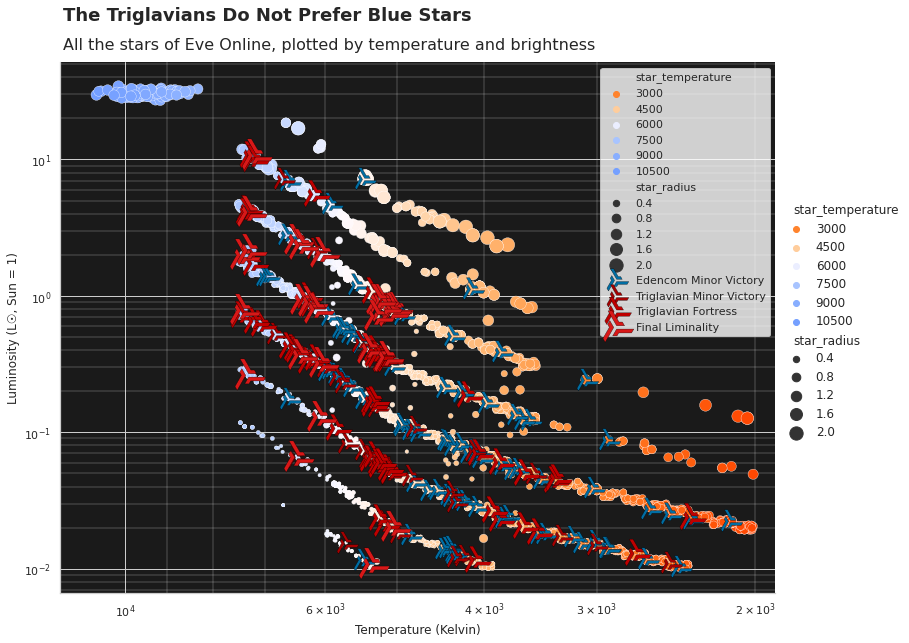

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
blackbody_cm = blackbody_color_map(star_data['star_temperature'])

g = sns.relplot(
    x='star_temperature', y='star_luminosity',
    data=star_data, kind='scatter',
    hue='star_temperature', palette=blackbody_cm,
    size='star_radius', sizes=(10, 200),
    height=8, aspect=1.33, legend='brief')

trig_stars = star_data[star_data.invasion_status.notnull()]
trig_opts = dict(marker=trig_logo, edgecolors='#000000', linewidths=0.3)

eden_mvs = trig_stars[trig_stars.invasion_status == 'edencom_minor_victory']
plt.scatter(x=eden_mvs.star_temperature, y=eden_mvs.star_luminosity,
            **trig_opts, s=600, c='#006da3', label='Edencom Minor Victory')

trig_mvs = trig_stars[trig_stars.invasion_status == 'triglavian_minor_victory']
plt.scatter(x=trig_mvs.star_temperature, y=trig_mvs.star_luminosity,
            **trig_opts, s=600, c='#A50000', label='Triglavian Minor Victory')

trig_for = trig_stars[trig_stars.invasion_status == 'fortress']
plt.scatter(x=trig_for.star_temperature, y=trig_for.star_luminosity,
            **trig_opts, s=900, c='#BF0000', label='Triglavian Fortress')

trig_fin = trig_stars[trig_stars.invasion_status == 'final_liminality']
plt.scatter(x=trig_fin.star_temperature, y=trig_fin.star_luminosity,
            **trig_opts, s=1200, c='#D81818', label='Final Liminality')
# Colors derived from https://images.evetech.net/corporations/500026/logo?size=128
# And https://www.hexcolortool.com/#d81818


#  Title and Subtitle
g.fig.text(s="The Triglavians Do Not Prefer Blue Stars",
           fontsize=18, fontweight='bold', ha='left', x=0.05, y=1.05)
g.fig.text(s='All the stars of Eve Online, plotted by temperature and brightness',
           fontsize=16, ha='left', x=0.05, y=1.00)

g.set_axis_labels(x_var='Temperature (Kelvin)', y_var='Luminosity (L☉, Sun = 1)')
g.set(xscale='log', yscale='log', xlim=(11800, 1900))
g.ax.xaxis.grid(True, "minor", linewidth=.25, c='w')
g.ax.yaxis.grid(True, "minor", linewidth=.25, c='w')
g.ax.set_facecolor('0.1')
plt.legend()
# g.despine(left=True, bottom=True);


# Save the figure
g.savefig('triglavian_stars.png', transparent=False, dpi=150)

# https://seaborn.pydata.org/generated/seaborn.relplot.html
# https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
# https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn.scatterplot

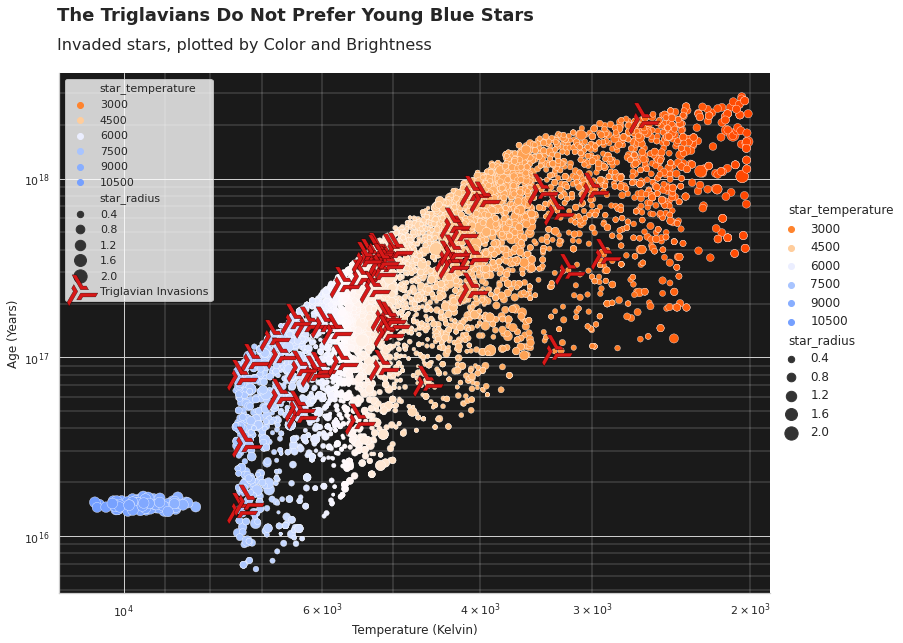

In [ ]:
g = sns.relplot(
    x='star_temperature', y='star_age',
    data=star_data, kind='scatter',
    hue='star_temperature', palette=blackbody_cm,
    size='star_radius', sizes=(10, 200),
    height=8, aspect=1.33, legend='brief')

trig_stars = star_data[star_data.invader == 'Triglavians']
plt.scatter(x=trig_stars.star_temperature, y=trig_stars.star_age,
            label='Triglavian Invasions', marker=trig_logo, s=1200, c='#D81818',
            edgecolors='#000000', linewidths=0.3)

#  Title and Subtitle
g.fig.text(s="The Triglavians Do Not Prefer Young Blue Stars",
           fontsize=18, fontweight='bold', ha='left', x=0.05, y=1.05)
g.fig.text(s='Invaded stars, plotted by Color and Brightness',
           fontsize=16, ha='left', x=0.05, y=1.00)

# Spines & Gridlines
g.set_axis_labels(x_var='Temperature (Kelvin)', y_var='Age (Years)')
g.set(xscale='log', yscale='log', xlim=(11800, 1900))
g.ax.xaxis.grid(True, "minor", linewidth=.25, c='w')
g.ax.yaxis.grid(True, "minor", linewidth=.25, c='w')
g.ax.set_facecolor('0.1')
plt.legend()

# Save the figure
g.savefig('triglavian_stars.png', transparent=False, dpi=150)

# https://seaborn.pydata.org/generated/seaborn.relplot.html
# https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
# https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn.scatterplot

# Hypothesis Testing #

## Star Temperature ##

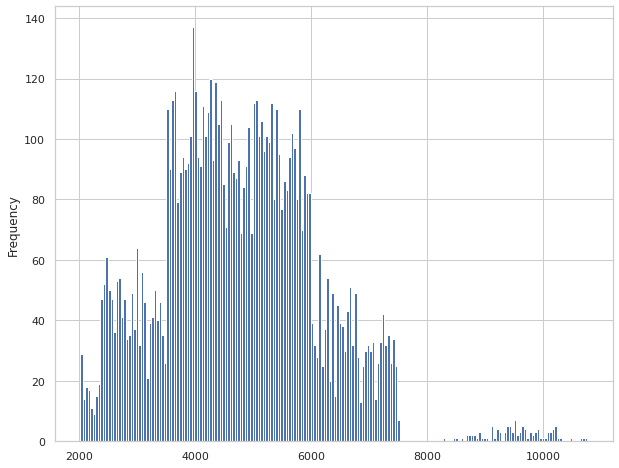

In [ ]:
plt.figure(figsize=(12,8))
star_data.star_temperature.plot.hist(label='All Stars', bins=200)

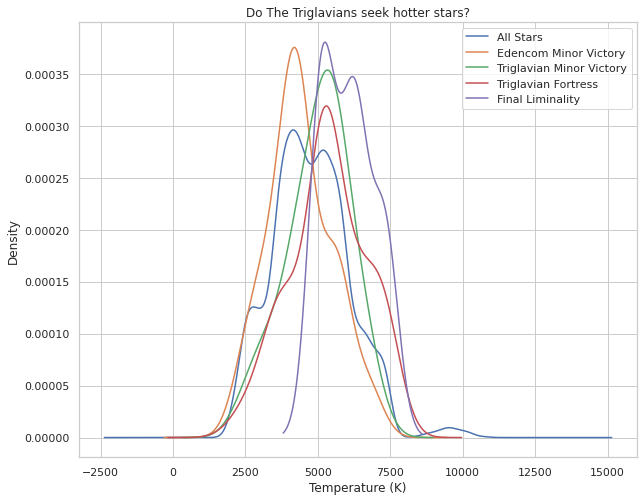

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.set(xlabel='Temperature (K)', ylabel='Probability')
plt.title('Do The Triglavians seek hotter stars?')

star_data.star_temperature.plot.density(label='All Stars')

eden_mvs = trig_stars[trig_stars.invasion_status == 'edencom_minor_victory']
eden_mvs.star_temperature.plot.density(label='Edencom Minor Victory')

trig_mvs = trig_stars[trig_stars.invasion_status == 'triglavian_minor_victory']
trig_mvs.star_temperature.plot.density(label='Triglavian Minor Victory')

trig_for = trig_stars[trig_stars.invasion_status == 'fortress']
trig_for.star_temperature.plot.density(label='Triglavian Fortress')

trig_fin = trig_stars[trig_stars.invasion_status == 'final_liminality']
trig_fin.star_temperature.plot.density(label='Final Liminality')

plt.legend()
plt.show()

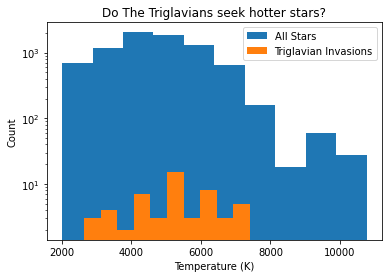

In [ ]:
ax = plt.gca()
population_temps = star_data.star_temperature
population_temps.plot.hist(label='All Stars')
triglavian_temps = trig_stars.star_temperature
triglavian_temps.plot.hist(label='Triglavian Invasions')
ax.set(xlabel='Temperature (K)', ylabel='Count')
plt.title('Do The Triglavians seek hotter stars?')
ax.set(yscale='log')
plt.legend()
plt.show()

## Security Status ##
<img src="https://github.com/jrslagle/EVE-Triglavian-Invasions/blob/main/sampe_map_view.png?raw=true" width=100%>

In Eve, all solar systems have a security status. This is a number between -1.0 and 1.0 with higher numbers being safer. Systems are divided into subtypes by security status.

There are 8,035 solar systems total, divided into New Eden and Wormhole space.
- New Eden is 5,431 systems all networked by warp gates and is divided into Empire Space and Nullsec.
 - Empire space is 1,907 systems, and is divided into Highsec and Lowsec
   - Highsec systems have a security between 1.0 and 0.5. (1,212 systems)
   - Lowsec systems have a security between 0.4 and 0.1. (695 systems)
 - Nullsec systems have a security between -0.0 and -1.0. (3,524 systems)
- Wormhole space is 2,604 systems and are not connected to the warpgate network and always have a security of -0.99.

Security status loosely represents how safe you are from non-consentual PVP (player vs player combat). In highsec, this is regulated by the response time of the police (Concord) and by the strength of turrets around stations and warp gates. In lowsec, there is no police response, but there are still (weaker) protective turrets around stations and warp gates. This is effective at reducing non-consentual PVP, but doesn't eliminate it.


After a lot of screenshots in game, and color histograms, I've figured out a few things about the relationship between security status and it's color code in game. First of all, each solar system has a true security status which is a float number with 6 digits after the decimal point. However, the security status in game is a 1 digit float number. Through measuring the colors of a variety of true securities, I discovered the color used for security status in game uses the rounded security status and not the true security status. Also, the rounding behavior is 0.05 rounds up, 0.049 rounds down to the nearest 0.1, such as:

<table>
  <tr>
    <th>System</th>
    <th>True Sec</th>
    <th>Round Sec</th>
  </tr>
  <tr>
    <td>Usteli</td>
    <td>0.950595</td>
    <td>1.000</td>
  </tr>
  <tr>
    <td>Tew</td>
    <td>0.949794</td>
    <td>0.900</td>
  </tr>
</table>

This can be accomplished with `star_data['security'].round(decimals=1)`. However, things get weird around a security of zero. Securities > 0 are in lowsec, and securities < 0 are in nullsec.



In [113]:
# Split the systems into their main groups

# split off k-space or known space, which are all the systems reachable by warp gates
# this excludes the wormhole systems
k_space = star_data[star_data.domain == 'eve']
print('There are',len(k_space),'systems in K-Space / New Eden')

# split off Empire systems
empire_regions = k_space.region[k_space.security > 0].unique()
empire_mask = k_space.region.isin(empire_regions)
empire_space = k_space[empire_mask]
print('There are',len(empire_space),'systems in Empire Space')
print('The empire regions are:')
print(empire_regions)

# split off Nullsec
null_space = k_space[~empire_mask]
print('There are',len(null_space),'systems in Nullsec')

# split off wormhole systems
wh_space = star_data[star_data.domain == 'wormhole']
print('There are',len(wh_space),'systems in W-Space / J-Space / Wormhole Space')

There are 5431 systems in K-Space / New Eden
There are 1907 systems in Empire Space
The empire regions are:
['Aridia' 'BlackRise' 'Derelik' 'Devoid' 'Domain' 'Essence' 'Everyshore'
 'Genesis' 'Heimatar' 'Kador' 'Khanid' 'Kor-Azor' 'Lonetrek' 'Metropolis'
 'MoldenHeath' 'Placid' 'SinqLaison' 'Solitude' 'Tash-Murkon'
 'TheBleakLands' 'TheCitadel' 'TheForge' 'VergeVendor']
There are 3524 systems in Nullsec
There are 2604 systems in W-Space / J-Space / Wormhole Space


In [138]:
# Creating a rounded version of star security status, as it's seen in the game.
k_space['security_round'] = k_space.loc[:,'security'].round(decimals=1)
non_null_low = (k_space.loc[:,'security'] > 0) & (k_space.loc[:,'security_round'] == 0)
k_space.loc[:,'security_round'][non_null_low] = 0.1  # this applies to 14 systems
k_space['security_round'].value_counts().sort_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._wher

-1.0     63
-0.9     96
-0.8    126
-0.7    181
-0.6    228
-0.5    267
-0.4    340
-0.3    421
-0.2    564
-0.1    679
-0.0    559
 0.1     89
 0.2    131
 0.3    216
 0.4    259
 0.5    267
 0.6    280
 0.7    230
 0.8    226
 0.9    155
 1.0     54
Name: security_round, dtype: int64

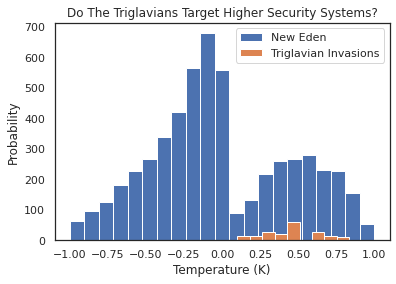

In [139]:
import matplotlib.pyplot as plt

k_space.security_round.plot.hist(bins=21, label='New Eden')

trig_stars = k_space[k_space['invasion_status'].notnull()]
trig_stars.security_round.plot.hist(bins=11, label='Triglavian Invasions')

ax = plt.gca()
ax.set(xlabel='Temperature (K)', ylabel='Probability')
plt.title('Do The Triglavians Target Higher Security Systems?')
plt.legend()
plt.show()

TypeError: ignored

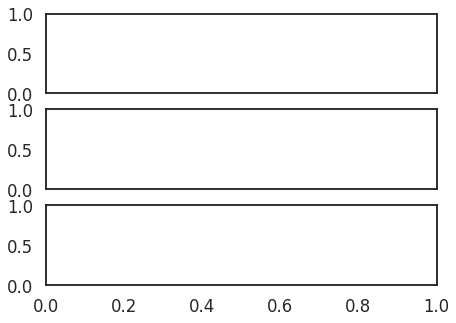

In [143]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# Generate some sequential data
x = np.array(list("ABCDEFGHIJ"))
y1 = np.arange(1, 11)
sns.barplot(x=x, y=y1, palette=security_cm, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")

# Generate some sequential data
x = np.array(list("ABCDEFGHIJ"))
y1 = np.arange(1, 11)
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")

# Center the data to make it diverging
y2 = y1 - 5.5
sns.barplot(x=x, y=y2, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Diverging")

# Randomly reorder the data to make it qualitative
y3 = rs.choice(y1, len(y1), replace=False)
sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Qualitative")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [109]:
# mask = (k_space.security_round > 0) & (k_space.security_round <= 0.4)
mask = (k_space.security_round == 0.4)
k_space[['system_name','security','security_round']][mask].sort_values(by='security')

,system_name,security,security_round
4050,Yveve,0.351355,0.4
2612,Perbhe,0.351467,0.4
2628,Nebian,0.351497,0.4
4709,Oijanen,0.351969,0.4
2464,Oberen,0.352251,0.4
...,...,...,...
4031,Egghelende,0.449268,0.4
2918,Erstet,0.449402,0.4
1298,Palmon,0.449710,0.4
2541,Rilera,0.449848,0.4


In [118]:
# Get the security status for a specific system by name
star_data.security[star_data.system_name == 'JB-007']

4999   -0.001171
Name: security, dtype: float64

In [ ]:
sec = 0.029147
round_sec = sec

In [134]:
# Lists systems near a target security value
target = 0.011
margin = 0.02
mask = (k_space.security > target-margin) & (k_space.security < target+margin)
k_space[['system_name','security','security_round']][mask].sort_values(by='security')

,system_name,security,security_round
3779,KEJY-U,-8.984716e-03,-0.0
3798,V-3U8T,-8.970726e-03,-0.0
4282,RLL-9R,-8.892641e-03,-0.0
435,6ON-RW,-8.812565e-03,-0.0
2013,7-IDWY,-8.712267e-03,-0.0
...,...,...,...
5005,B-DXO9,-1.822197e-06,-0.0
5006,H472-N,-1.344346e-06,-0.0
5004,1TS-WN,-9.835969e-07,-0.0
5003,16-31U,-9.709390e-07,-0.0


Security color values are relatively consistent across a round sec level, and then change dramatically at the border between two round sec levels:

<table>
  <tr>
    <th>System</th>
    <th>True Sec</th>
    <th>Round Sec</th>
    <th>Red</th>
    <th>Green</th>
    <th>Blue</th>
  </tr>
  <tr>
    <td>Amarr</td>
    <td>1.000000</td>
    <td>1.00</td>
    <td>41.05</td>
    <td>193.46</td>
    <td>193.2</td>
  </tr>
  <tr>
    <td>Irnal</td>
    <td>0.950759</td>
    <td>1.00</td>
    <td>41.69</td>
    <td>192.95</td>
    <td>192.72</td>
  </tr>
  <tr>
    <td>Tew</td>
    <td>0.949794</td>
    <td>0.90</td>
    <td>59.94</td>
    <td>193.40</td>
    <td>155.36</td>
  </tr>
  <tr>
    <td>Vittenyn</td>
    <td>0.903550</td>
    <td>0.90</td>
    <td>59.83</td>
    <td>193.67</td>
    <td>155.67</td>
  </tr>
  <tr>
    <td>Airkio</td>
    <td>0.851633</td>
    <td>0.90</td>
    <td>60.06</td>
    <td>192.83</td>
    <td>154.72</td>
  </tr>
</table>

<img src="https://github.com/jrslagle/EVE-Triglavian-Invasions/blob/main/sample_route.png?raw=true" width=282>

Color values were derivied by plotting routes across those systems, which displays an 8x8 square in the security color of that system. Then I used the average pixel color in that square. Since it appears these squares are a little transparent, care was taken to provide as dark a background as possible. This was done for each round sec level and then turned into a colormap.

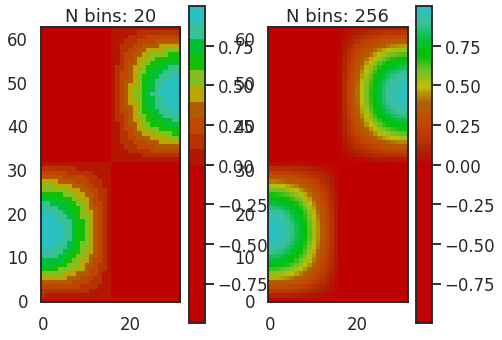

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sec_colors = {
    'red': ((0.00, 0.75, 0.75),
          (0.50, 0.75, 0.75),
          (0.55, 0.6756640625, 0.6756640625),
          (0.60, 0.75, 0.75),
          (0.65, 0.75, 0.75),
          (0.70, 0.675859375, 0.675859375),
          (0.75, 0.75, 0.75),
          (0.80, 0.453203125, 0.453203125),
          (0.85, 0.00, 0.00),
          (0.90, 0.007, 0.007),
          (0.95, 0.234153645833333, 0.234153645833333),
          (1.00, 0.1616015625, 0.1616015625)),

    'green': ((0.00, 0.007, 0.007),
          (0.50, 0.007, 0.007),
          (0.55, 0.1554296875, 0.1554296875),
          (0.60, 0.2296875, 0.2296875),
          (0.65, 0.30390625, 0.30390625),
          (0.70, 0.378046875, 0.378046875),
          (0.75, 0.75, 0.75),
          (0.80, 0.75, 0.75),
          (0.85, 0.753125, 0.753125),
          (0.90, 0.753125, 0.753125),
          (0.95, 0.755078125, 0.755078125),
          (1.00, 0.75470703125, 0.75470703125)),

    'blue': ((0.00, 0.007, 0.007),
          (0.75, 0.007, 0.007),
          (0.80, 0.155, 0.155),
          (0.85, 0.007, 0.007),
          (0.90, 0.2292578125, 0.2292578125),
          (0.95, 0.6064453125, 0.6064453125),
          (1.00, 0.75375, 0.75375))} 
security_cm = LinearSegmentedColormap('Security', sec_colors)
# Make some illustrative fake data:
x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.sin(Y)

# colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
n_bins = [20, 256]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
fig, axs = plt.subplots(1, 2, figsize=(6, 5))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)
for n_bin, ax in zip(n_bins, axs.ravel()):
    # Create the colormap
    security_cm = LinearSegmentedColormap('Security', sec_colors, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, origin='lower', cmap=security_cm)
    ax.set_title("N bins: %s" % n_bin)
    fig.colorbar(im, ax=ax)

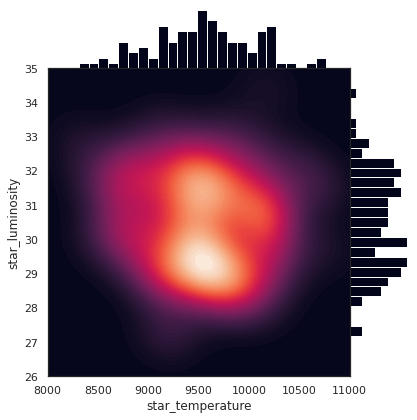

In [ ]:
# A fancy plot of the 
import seaborn as sns

bright_stars = star_data[star_data['star_type_id'] == 34331]
sns.set_theme(style="white")
g = sns.JointGrid(data=bright_stars, x="star_temperature", y="star_luminosity", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((8000, 11000), (26, 35)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25);

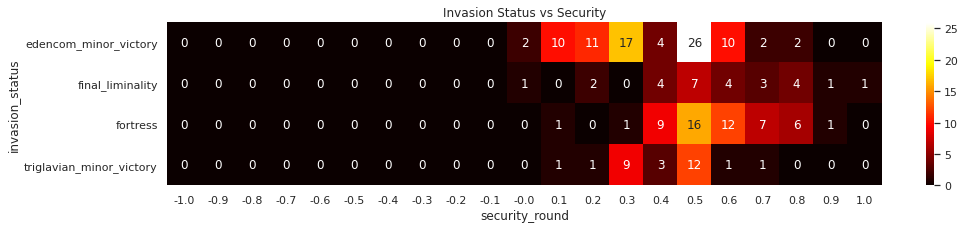

In [83]:
# A heatmap of security status vs invasion status
# I wanted to know if certain star types were for null-sec only
import seaborn as sns
plt.figure(figsize=(16,3))
crosstab = pd.crosstab(index=k_space.invasion_status, columns=k_space.security_round, dropna=False)
sns.heatmap(crosstab, cmap='hot', annot=True)
plt.title('Invasion Status vs Security')
plt.show()

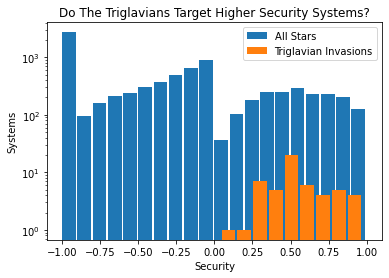

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
ax = plt.gca()

star_data.security_round.plot.hist(bins=20, width=.09, label='All Stars')


eden_mvs = trig_stars[trig_stars.invasion_status == 'edencom_minor_victory']
eden_mvs.star_temperature.plot.density(label='Edencom Minor Victory')

trig_mvs = trig_stars[trig_stars.invasion_status == 'triglavian_minor_victory']
trig_mvs.star_temperature.plot.density(label='Triglavian Minor Victory')

trig_for = trig_stars[trig_stars.invasion_status == 'fortress']
trig_for.star_temperature.plot.hist(label='Triglavian Fortress')

trig_fin = trig_stars[trig_stars.invasion_status == 'final_liminality']

triglavian_sec = trig_stars.security
triglavian_sec.plot.hist(bins=9, width=.09, label='Triglavian Invasions')
ax.set(xlabel='Security', ylabel='Number of Systems')
ax.set(xlim=(-1.1,1.1))
ax.set(yscale='log')
plt.title('Triglavian Invasions vs Security Status')
plt.legend()
plt.show()

In [ ]:
eve_stars = star_data[star_data['domain'] == 'eve']
eve_stars

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,invader,system_id,status,invasion_status,security_rounded,security_round
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.02956,125100000.0,G5 VI,5378.0,NaN,NaN,NaN,NaN,-0.0,-0.0
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.10810,155800000.0,K1 V,4713.0,NaN,NaN,NaN,NaN,-0.0,-0.0
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.29050,161000000.0,G0 V,5936.0,NaN,NaN,NaN,NaN,-0.0,-0.0
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.30090,106600000.0,F0 VI,7360.0,NaN,NaN,NaN,NaN,-0.0,-0.0
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.01935,226400000.0,K9 V,3596.0,NaN,NaN,NaN,NaN,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5426,eve,WickedCreek,RF9-ZU,H-HHTH,-0.421542,30000547,40034158,45039,1.588000e+18,2.303000e+18,False,0.03290,536700000.0,M4 V,2668.0,NaN,NaN,NaN,NaN,-0.4,-0.4
5427,eve,WickedCreek,RF9-ZU,JQU-KY,-0.267341,30000548,40034226,6,1.664000e+17,4.033000e+17,False,0.41290,481600000.0,G6 V,5300.0,NaN,NaN,NaN,NaN,-0.3,-0.3
5428,eve,WickedCreek,RF9-ZU,MWA-5Q,-0.307662,30000546,40034109,9,4.656000e+16,2.004000e+17,False,0.37420,316200000.0,F7 VI,6382.0,NaN,NaN,NaN,NaN,-0.3,-0.3
5429,eve,WickedCreek,RF9-ZU,UY5A-D,-0.404798,30000549,40034268,6,3.951000e+17,4.787000e+17,False,0.85090,727800000.0,G8 V,5166.0,NaN,NaN,NaN,NaN,-0.4,-0.4


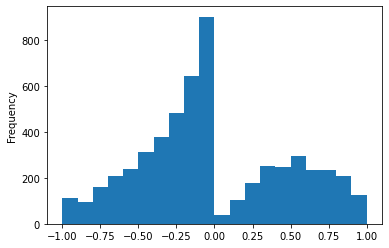

In [ ]:
eve_stars.security.plot.hist(bins=20);

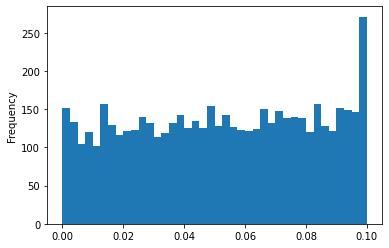

In [ ]:
(eve_stars.security % 0.1).plot.hist(bins=40);

## Spectral Class ##

In [ ]:
star_data.star_spectralClass.unique()

array(['G5 VI', 'K1 V', 'G0 V', 'F0 VI', 'K9 V', 'G2 V', 'M0 V', 'M2 V',
       'K5 V', 'K6 IV', 'F6 V', 'K7 V', 'K8 V', 'M9 V', 'K3 V', 'G2 VI',
       'K0 V', 'M5 V', 'F5 VI', 'G8 VI', 'K9 IV', 'M6 V', 'F3 IV', 'M7 V',
       'K2 V', 'F7 VI', 'F2 VI', 'M1 V', 'G5 V', 'M4 V', 'G7 VI', 'K4 V',
       'M8 V', 'G7 V', 'G6 VI', 'G8 V', 'F6 VI', 'G9 VI', 'K6 V', 'G9 V',
       'F4 V', 'G3 V', 'F5 V', 'F7 V', 'G1 VI', 'F9 VI', 'G4 V', 'G0 IV',
       'M3 V', 'F1 V', 'G6 V', 'K0 IV', 'G1 V', 'F1 VI', 'F8 VI', 'K5 IV',
       'G3 VI', 'G0 VI', 'F0 V', 'F2 V', 'F4 VI', 'G2 IV', 'K1 IV',
       'G4 VI', 'F8 V', 'F3 V', 'F9 V', 'K3 IV', 'K4 IV', 'F3 VI',
       'K2 IV', 'G1 IV', 'G3 IV', 'G5 IV', 'F2 IV', 'F6 IV', 'F5 IV',
       'K8 IV', 'F1 IV', 'G4 IV', 'F0 IV', 'F9 IV', 'F4 IV', 'G7 IV',
       'K7 IV', 'G8 IV', 'A0IV', 'A0', 'A0IV2'], dtype=object)

In [ ]:
type_ids = star_data.star_type_id.unique()
spectral_classes = star_data.star_spectralClass.unique()
print('There are',len(type_ids),'star types in Eve and',len(spectral_classes),'spectral classes.')

print('Type ID: Spectral Classes')
spectral_classes_2 = []
for type_id in sorted(type_ids):
  these_spectral_classes = star_data.star_spectralClass[star_data.star_type_id == type_id].unique()
  spectral_classes_2.extend(these_spectral_classes)
  print(str(type_id)+':',sorted(these_spectral_classes))
repeats = len(spectral_classes_2) - len(spectral_classes)
print('That\'s a list of',len(spectral_classes_2),'spectral classes, so there are',repeats,'repeats.')

There are 29 star types in Eve and 89 spectral classes.
Type ID: Spectral Classes
6: ['G6 V', 'G6 VI', 'G7 IV', 'G7 V', 'G7 VI', 'G8 IV', 'G8 V', 'G8 VI', 'G9 V', 'G9 VI']
7: ['K7 IV', 'K7 V', 'K8 IV', 'K8 V', 'K9 IV', 'K9 V']
8: ['K5 IV', 'K5 V', 'K6 IV', 'K6 V']
9: ['F6 V', 'F6 VI', 'F7 V', 'F7 VI']
10: ['F2 IV', 'F2 V', 'F2 VI', 'F3 IV', 'F3 V', 'F3 VI']
3796: ['F0 IV', 'F0 V', 'F0 VI', 'F1 IV', 'F1 V', 'F1 VI']
3797: ['G3 IV', 'G3 V', 'G3 VI', 'G4 IV', 'G4 V', 'G4 VI', 'G5 IV', 'G5 V', 'G5 VI']
3798: ['K3 IV', 'K3 V', 'K4 IV', 'K4 V']
3799: ['G0 IV', 'G0 V', 'G0 VI', 'G1 IV', 'G1 V', 'G1 VI', 'G2 IV', 'G2 V', 'G2 VI']
3800: ['M0 V', 'M1 V', 'M2 V', 'M3 V', 'M4 V', 'M5 V', 'M6 V', 'M7 V', 'M8 V', 'M9 V']
3801: ['F0 V', 'F0 VI', 'F1 IV', 'F1 V', 'F1 VI', 'F6 V', 'F8 V', 'F8 VI', 'F9 IV', 'F9 V', 'F9 VI']
3802: ['K0 IV', 'K0 V', 'K1 IV', 'K1 V', 'K2 IV', 'K2 V']
3803: ['F4 V', 'F4 VI', 'F5 V', 'F5 VI']
34331: ['A0', 'A0IV', 'A0IV2']
45030: ['G6 V', 'G6 VI', 'G7 IV', 'G7 V', 'G7 VI', '

In [ ]:
# Parsing out the Morgan–Keenan Spectral class of each star's spectral class
spec = star_data.star_spectralClass.str.extract(r'(?P<Type>[\w])(?P<Subtype>\d) ?(?P<Magnitude>[IV]+)')
spec

,Type,Subtype,Magnitude
0,G,5,VI
1,K,1,V
2,G,0,V
3,F,0,VI
4,K,9,V
...,...,...,...
8030,A,0,IV
8031,A,0,IV
8032,A,0,IV
8033,A,0,IV


In [ ]:
spec.Type.value_counts(normalize=True)

K    0.418471
G    0.266990
M    0.158701
F    0.142768
A    0.013069
Name: Type, dtype: float64

In [ ]:
# A heatmap of security status vs star type
# I wanted to know if certain star types were for null-sec only

pd.crosstab(index=spec.Type, columns=star_data.invasion_status, margins=True)


invasion_status,edencom_minor_victory,final_liminality,fortress,triglavian_minor_victory,All
Type,,,,,
F,5,16,17,4,42
G,17,11,23,12,63
K,45,0,8,9,62
M,17,0,5,3,25
All,84,27,53,28,192


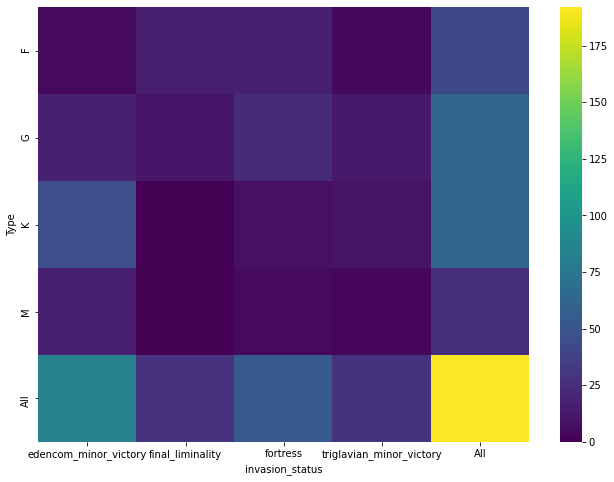

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11,8))
crosstab = pd.crosstab(index=spec.Type, columns=star_data.invasion_status, margins=True)
sns.heatmap(crosstab, cmap='viridis')
plt.show()

In [ ]:
star_type_descriptions = {
6: 
7: 
8: 
9: 'B0 (Blue)'
10: 
3796: 
3797: 
3798: 
3799: 
3800: 
3801: 'A0 (Blue Small)'
3802: 
3803: 
34331: 
45030: 'G5 (Yellow)'
45031: 
45032: 
45033: 
45034: 
45035: 
45036: 
45037: 
45038: 
45039: 
45040: 
45041: 
45042: 
45046: 'B0 (Blue)'
45047: }

In [ ]:
star_data

,domain,region,constellation,system_name,security,solar_system_id,star_id,star_type_id,star_age,star_life,star_locked,star_luminosity,star_radius,star_spectralClass,star_temperature,invader
0,eve,A821-A,6I-9Y2,E-RPGP,-0.032727,30001620,40103256,3797,2.956000e+17,3.839000e+17,False,0.029560,1.251000e+08,G5 VI,5378.000000,NaN
1,eve,A821-A,6I-9Y2,KER-EU,-0.043516,30001623,40103397,45041,3.909000e+16,6.139000e+17,False,0.108100,1.558000e+08,K1 V,4713.000000,NaN
2,eve,A821-A,6I-9Y2,NSE-U1,-0.023518,30001622,40103340,3799,1.610000e+17,2.555000e+17,False,0.290500,1.610000e+08,G0 V,5936.000000,NaN
3,eve,A821-A,6I-9Y2,R79-I7,-0.035995,30001619,40103231,3801,3.688000e+16,9.518000e+16,False,0.300900,1.066000e+08,F0 VI,7360.000000,NaN
4,eve,A821-A,6I-9Y2,UC-X28,-0.033132,30001618,40103183,45032,1.445000e+18,1.571000e+18,False,0.019350,2.264000e+08,K9 V,3596.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8030,wormhole,K-R00033,K-C00334,J055520,-0.990000,31000001,40488458,34331,1.531382e+16,2.947934e+16,False,29.998348,1.255450e+09,A0IV2,9494.425593,Drifters
8031,wormhole,K-R00033,K-C00334,J110145,-0.990000,31000002,40488467,34331,1.544513e+16,3.176256e+16,False,31.258190,1.215493e+09,A0IV2,9113.553610,Drifters
8032,wormhole,K-R00033,K-C00334,J164710,-0.990000,31000003,40488473,34331,1.455343e+16,2.914124e+16,False,31.000799,1.205544e+09,A0IV2,10100.005251,Drifters
8033,wormhole,K-R00033,K-C00334,J174618,-0.990000,31000006,40488495,34331,1.489648e+16,2.996210e+16,False,29.021719,1.312762e+09,A0IV2,9859.320181,Drifters


In [ ]:
client.Universe.get_universe_stars_star_id(star_id=40103340).result()

get_universe_stars_star_id_ok(age=5101781916, luminosity=0.2904999852180481, name='NSE-U1 - Star', radius=161000000, solar_system_id=30001622, spectral_class='G0 V', temperature=5936, type_id=3799)

In [ ]:
client.Search.get_search(categories=['station'],search='Botane - IChooseYou Market and Industry').result()

get_search_ok(agent=None, alliance=None, character=None, constellation=None, corporation=None, faction=None, inventory_type=None, region=None, solar_system=None, station=None)

In [ ]:


# check for number of categorical vs numeric columns
cat_cols = national.columns[national.dtypes=='object']
num_cols = national.columns[national.dtypes!='object']

print(f'{len(cat_cols)} categorical columns')
print(f'{len(num_cols)} numerical columns')

# We're making a copy of our data in case we mess something up.
national_processed = national.copy()

# Categorically Encode our Variables:
# They need to all be numeric before we do PCA.
# https://pbpython.com/categorical-encoding.html

# Cast categorical columns to "category" data type
national_processed[cat_cols] = national_processed[cat_cols].astype('category')

national_processed.dtypes

# Replace all category cell values with their numeric category codes
for col in cat_cols:
  national_processed[col] = national_processed[col].cat.codes

national_processed

# Now we only have numeric columns (ints and floats)
national_processed.dtypes

types = star_data.star_type_id
plt.scatter(star_data.star_spectralClass, star_data.star_type_id)

In [ ]:
star_types = sorted(star_data.star_type_id.unique())
# src="https://images.evetech.net/types/3801/render?size=256"
for star_type in star_types:
  print('<div class="img-block"><img src="https://images.evetech.net/types/'+str(star_type)+'/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>')

NameError: ignored

<div class="img-block"><img src="https://images.evetech.net/types/45047/render?size=256"></div>

<div class="img-block"><img src="https://images.evetech.net/types/45046/render?size=512"></div>

<div class="img-block"><img src="https://images.evetech.net/types/6/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/7/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/8/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/9/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/10/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3796/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3797/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3798/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3799/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3800/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3801/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3802/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/3803/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/34331/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45030/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45031/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45032/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45033/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45034/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45035/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45036/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45037/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45038/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45039/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45040/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45041/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45042/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45046/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>
<div class="img-block"><img src="https://images.evetech.net/types/45047/render?size=256"><span class="sun-type">A0 (Blue Small)</span></div>

# Scratch #

# Sources #

Static Data Export for Eve Developers
https://developers.eveonline.com/resource/resources

